# Executive Summary

## 1. Project Overview 

The Home Credit Default Risk project aims to predict loan repayment ability of a potential lender.

The primary reason behing this project is caused by the fact that many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Hence, this project outcomes may result in broadening financial inclusion for the unbanked population by providing a positive and safe borrowing experience. 

In order to make sure under-served population have a positive loan experience, Home Credit has provided a variety of datasets (including telco and transactional information) to predict their clients' repayment abilities. 

This project will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful. 

## 2. Problem Statement 

In this project, we will attempt to solve the following problem statement is: 

**Can we predict how capable each applicant is of repaying a loan?**

The objective is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification problem where the label of target variable is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan).

Supervised learning is where you have input variables (x) and an output variable (Y) and you use an algorithm to learn the mapping function from the input to the output, in other words Y = f(X). The goal is to approximate the mapping function so well that when you have new input data (x) that you can predict the output variables (Y) for that data. 

## 3. Data Exploration

Home Credit has provided a variety of datasets to predict their clients' repayment abilities. 

Five separate *.csv files were used as part of this project: 

- application_train.csv:  static data for all applications. One row represents one loan in our data sample.


- bureau.csv: All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.


- POS_CASH_balance.csv: Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample # of relative previous credits # of months in which we have some history observable for the previous credits) rows.


- previous_application.csv: All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.


- installments_payments.csv: Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

## 4. Metrics 

The metrics chosen to measure performance of the results provided by the classification models in this project is the evaluation on area under the ROC curve between the predicted and the observed target. 

The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. An ROC curve plots True Positive Rate vs. False Positive Rate at different classification thresholds.

The Area Under the ROC Curve, also known as AUC, measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1). AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.


## 5. Findings

   1. As the client gets older, they are less likely to default on their loan.
   
   
   2. The longer the clients were employed, the less rate the clients having difficulties to pay their loan on time.
   
  
   3. EXT_SOURCE_1,2,3: the most important features in predicting the loan repayment ability of Client.
   

## 6. Risk/Limitation

As shown on later part, there are clearly many more loans that were repaid on time than loans that were not repaid. Indeed, observations with 'TARGET' value at 0 constitue 91.9% of the Training dataset. We see this is an **imbalanced class problem**.

Machine learning algorithms typically work best when the number of instances of each classes are roughly equal. We will have to address this target feature imbalance prior to implementing our Machine Learning algorithms.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from sklearn.utils import resample

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# define some useful functions:

def missing_values_table(df):
        # Total missing values
        missing_val = df.isnull().sum()
        
        # Percentage of missing values
        missing_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        missing_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
        
        # Rename the columns
        missing_val_table_columns = missing_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        missing_val_table_columns = missing_val_table_columns[
            missing_val_table_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("There are " + str(missing_val_table_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return missing_val_table_columns
    
    
    
def one_hot_encoder(df, nan_as_category = True):
    original_cols = list(df.columns)
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_cols, dummy_na= nan_as_category)
    new_cols = [c for c in df.columns if c not in original_cols]
    return df, new_cols

# 1. Loading data, preprocessing and EDA

## 1.1 Table: application train


In [2]:
# Main table data: application_train
app_train = pd.read_csv('./datasets/application_train.csv')
print('Application train data shape: ', app_train.shape)

Application train data shape:  (307511, 122)


### EDA : application_train

- Explore TARGET variable


- Explore some features  most correlated  with TARGET:
    - Client's Age
    - Employed days of Clients 
    
    
- Explore other features with TARGET:
    - Total Amount of Income
    - Amount of loan (AMT_CREDIT)
    - Number of children of client vs AMT_CREDIT
    - Number of family member of Client
    - Family status of the Clients vs AMT_CREDIT in term of Target variable
    - Education of Client
    - Income type of Client
    - Contract type
    - Occupation of Client
    - Occupation vs Income
    - Occupation vs Amount of loan
    

The feature 'TARGET' in the dataset is what this Machine Learning problem is about. We are trying to predict the value of the feature 'TARGET' by using other related features associated with the client's personal, professional, and credit history. 

Let's have a look at the distribution of the feature 'TARGET' in the Training dataset. The 'TARGET' feature has the value '0' (will repay loan on time) for 282.686 observations and the value '1' (will have difficulty repaying loan) for 24,825 observations.

In [5]:
app_train['TARGET'].value_counts()

# From this information, we see this is an imbalanced class problem. 
# There are far more loans that were repaid on time than loans that were not repaid.

0    282686
1     24825
Name: TARGET, dtype: int64

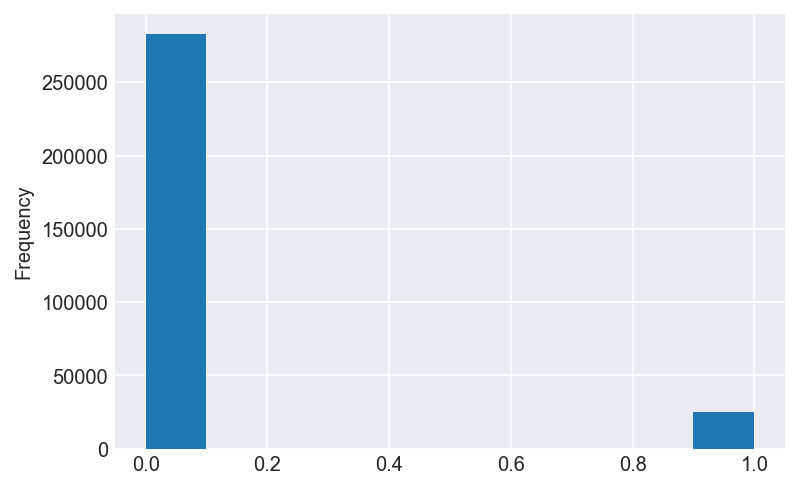

In [6]:
app_train['TARGET'].astype(int).plot.hist()

The target variable is imbalanced. 

**Strategy to solve:** we will use upsampling techniques to balance the training set.

In [7]:
app_train.dtypes
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Missing values check

In [16]:
missing_values_table(app_train).head(5)

There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


### Anomalies

In [4]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [5]:
# --> delete rows with CODE_GENDER == 'XNA'

In [9]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [7]:
# DAYS_EMPLOYED column

In [8]:
app_train['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [9]:
# --> max value is 365243, being employed more than 100 years?? Does that make sense?

In [10]:
len(app_train[app_train['DAYS_EMPLOYED'] == 365243])

55374

In [10]:
# there are 55374 rows with DAYS_EMPLOYED == 365234 --> we replace with NaN values
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

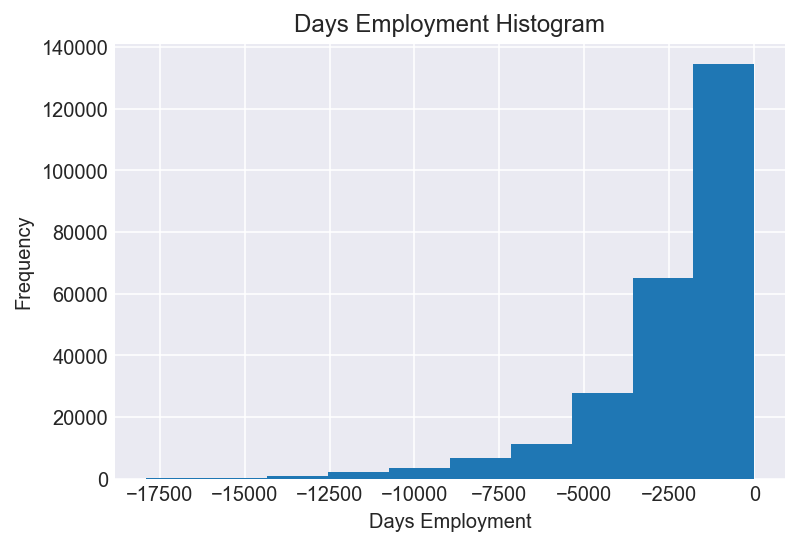

In [12]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### Correlation

In [32]:
# Find correlations with the target and sort
corr = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Top-15 Positive Correlations:\n', corr.tail(15))
print('\nTop-15 Negative Correlations:\n', corr.head(15))

Top-15 Positive Correlations:
 DAYS_REGISTRATION                                    0.041976
OCCUPATION_TYPE_Laborers                             0.043017
FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
DAYS_ID_PUBLISH                                      0.051457
DAYS_LAST_PHONE_CHANGE                               0.055219
NAME_INCOME_TYPE_Working                             0.057483
REGION_RATING_CLIENT                                 0.058901
REGION_RATING_CLIENT_W_CITY                          0.060895
DAYS_EMPLOYED                                        0.074957
DAYS_BIRTH                                           0.078242
TARGET                                               1.000000
Name: TARGET, dtype: float64

Top-15 Ne

Now we plot the top-2 positive correlations (DAYS_BIRTH and DAYS_EMPLOYED) and the top-3 negative correlations with the target (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3).

### Exploring positive correlation DAYS_BIRTH with Target variable

- The age in days of the client at the time of the loan in negative days (for whatever reason!). 

**Convert DAYS_BIRTH to age and display histogram of client's age**

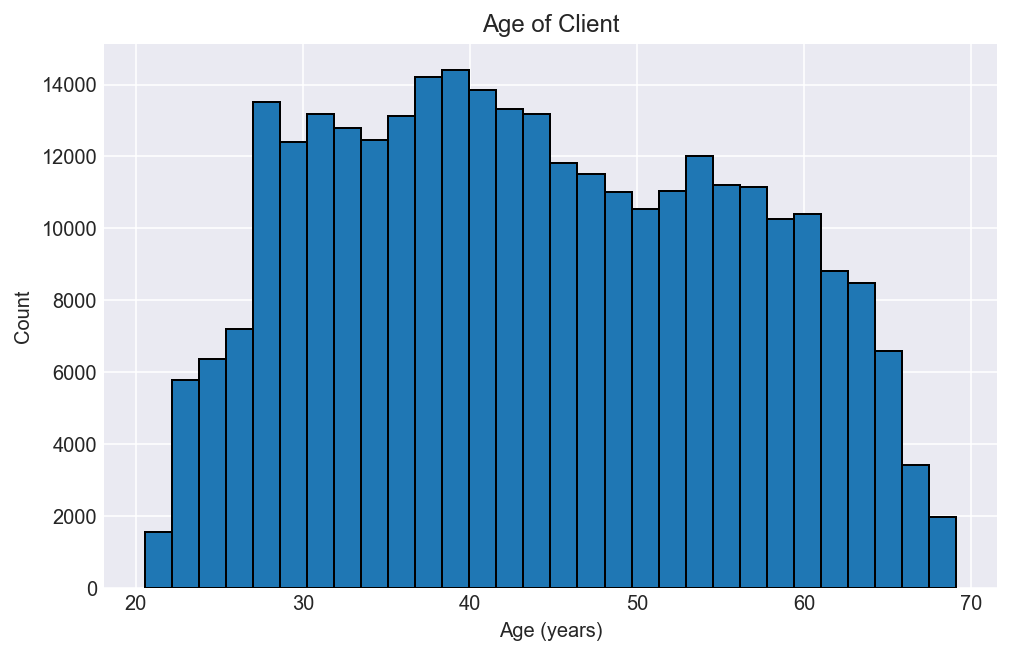

In [11]:
plt.figure(figsize = (8, 5))
plt.title('Age of Client')

plt.hist(abs(app_train['DAYS_BIRTH']) / 365, edgecolor = 'k', bins = 30)
plt.xlabel('Age (years)')
plt.ylabel('Count');

**Client's age and target variable**

In [23]:
age_df = app_train.loc[:,['DAYS_BIRTH','TARGET']]
age_df['AGE'] = abs(app_train['DAYS_BIRTH']) / 365


# creating age groups
age_df['AGES_BINNED'] = pd.cut(age_df['AGE'], bins = np.linspace(20, 70, num = 11))
#age_df.head(5)

In [25]:
age_df_agg = age_df.groupby(['AGES_BINNED','TARGET'])['TARGET'].count()
age_df_agg.unstack()
age_df_agg.head(4)

AGES_BINNED   TARGET
(20.0, 25.0]  0         10663
              1          1496
(25.0, 30.0]  0         29198
              1          3662
Name: TARGET, dtype: int64

Text(0.5,1,'Age Groups with Target')

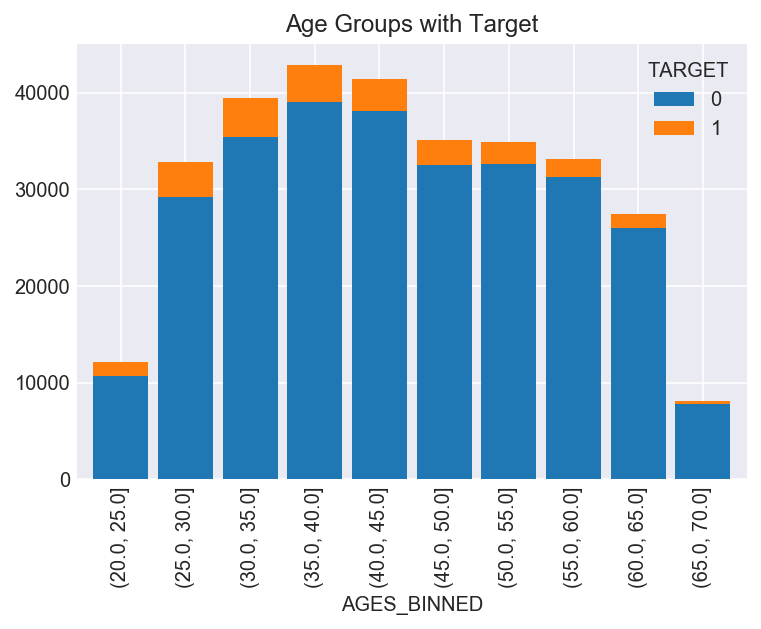

In [26]:
age_df_agg.unstack().plot(kind="bar", width=0.85, stacked = True)
plt.title('Age Groups with Target')

**Plotting percentage of repay failure in relation with client's age**

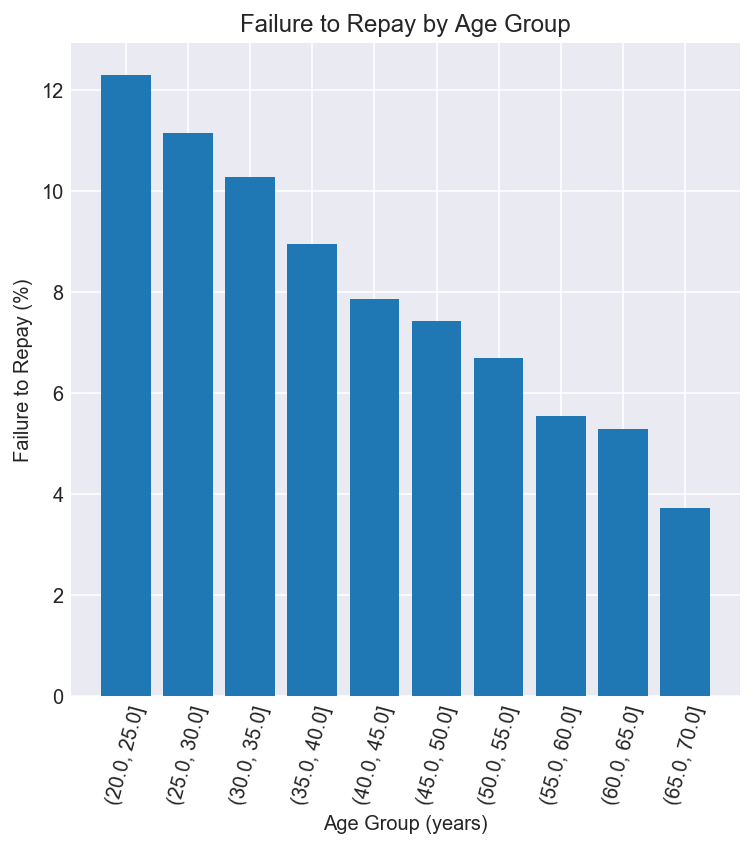

In [28]:
age_df_mean = age_df.groupby('AGES_BINNED').mean()

plt.figure(figsize = (6, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_df_mean.index.astype(str), 100 * age_df_mean['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

** Observation:**

- The correlation between client's Age and Target varibale is positive, but the acual value of DAYS_BiRTH is negative, meaning that if the DAYS_BIRTH change to be positive, the correlation with the target becomes negative. This means that as clients get older, they tend to repay their loans on time more often.

### Exploring positive correlation DAYS_EMPLOYED with TARGET variable

In [30]:
# convert to days to years
years_employed_df = app_train.loc[:,['DAYS_EMPLOYED', 'TARGET']]
years_employed_df['YEARS_EMPLOYED'] = abs(years_employed_df['DAYS_EMPLOYED'])/365
years_employed_df.head(3)

,DAYS_EMPLOYED,TARGET,YEARS_EMPLOYED
0,-637.0,1,1.745205
1,-1188.0,0,3.254795
2,-225.0,0,0.616438


In [31]:
# checking missing value
missing_values_table(years_employed_df)

There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_EMPLOYED,55374,18.0
YEARS_EMPLOYED,55374,18.0


In [32]:
years_employed_df['YEARS_EMPLOYED'].describe()

count    252133.000000
mean          6.531897
std           6.406377
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: YEARS_EMPLOYED, dtype: float64

In [33]:
# The data looks right, no outlier

In [40]:
# creating years_employed groups (bins)
years_employed_df['YEARS_EMPLOYED_BINNED'] = pd.cut(years_employed_df['YEARS_EMPLOYED'], bins = np.linspace(0, 60, num = 7))

In [42]:
years_employed_df.YEARS_EMPLOYED_BINNED.value_counts()

(0.0, 10.0]     201178
(10.0, 20.0]     38398
(20.0, 30.0]      9550
(30.0, 40.0]      2771
(40.0, 50.0]       234
(50.0, 60.0]         0
Name: YEARS_EMPLOYED_BINNED, dtype: int64

Text(0.5,1,'Years Employed Groups with Target')

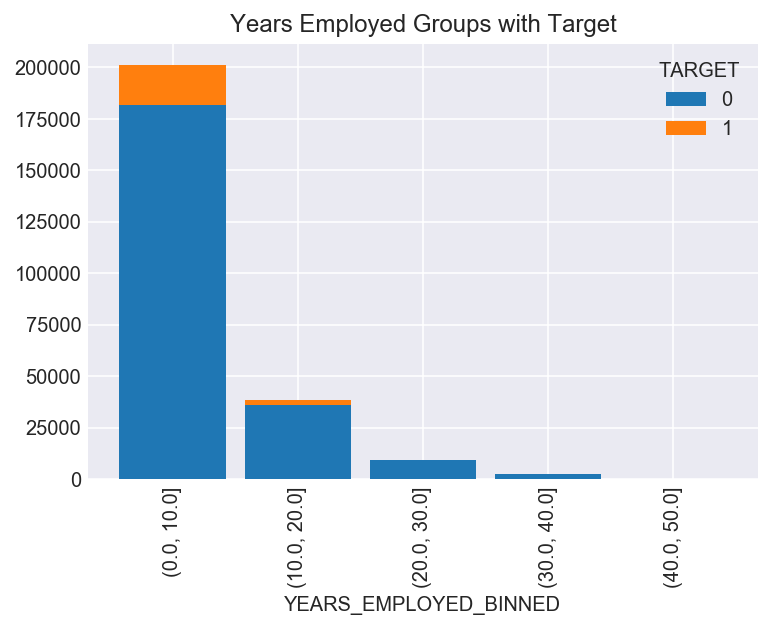

In [43]:
years_employed_df_agg = years_employed_df.groupby(['YEARS_EMPLOYED_BINNED','TARGET'])['TARGET'].count()
years_employed_df_agg.unstack()

years_employed_df_agg.unstack().plot(kind="bar", width=0.85, stacked = True)
plt.title('Years Employed Groups with Target')

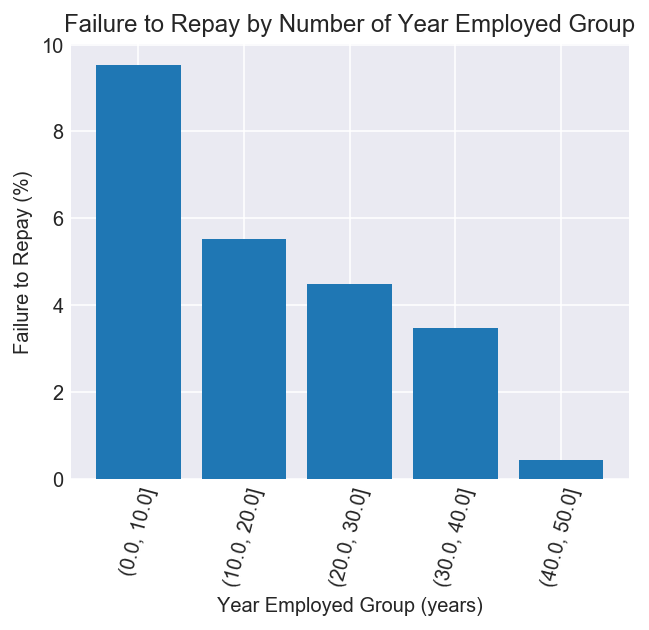

In [50]:
# Plotting percentage of repay failure in relation with the number of years client working

years_emp_df_mean = years_employed_df.groupby('YEARS_EMPLOYED_BINNED').mean()

plt.figure(figsize = (5, 4))

# Graph the age bins and the average of the target as a bar plot
plt.bar(years_emp_df_mean.index.astype(str), 100 * years_emp_df_mean['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Year Employed Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Number of Year Employed Group');

** Observation**

As the chart clearly states, the longer the clients were employed, the less rate the clients having diffivulties to pay their loan on time.

### Exploring Negative Correlations EXT_SOURCE 1,2,3 with Target variable

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the provided documentation, these features represent a "normalized score from external data source". Let zoom on these correlations.

In [53]:
ext_source_df = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
ext_source_df_corrs = ext_source_df.corr()
ext_source_df_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.155317,-0.160471,-0.178926
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186845
EXT_SOURCE_2,-0.160471,0.213982,1.000000,0.109182
EXT_SOURCE_3,-0.178926,0.186845,0.109182,1.000000


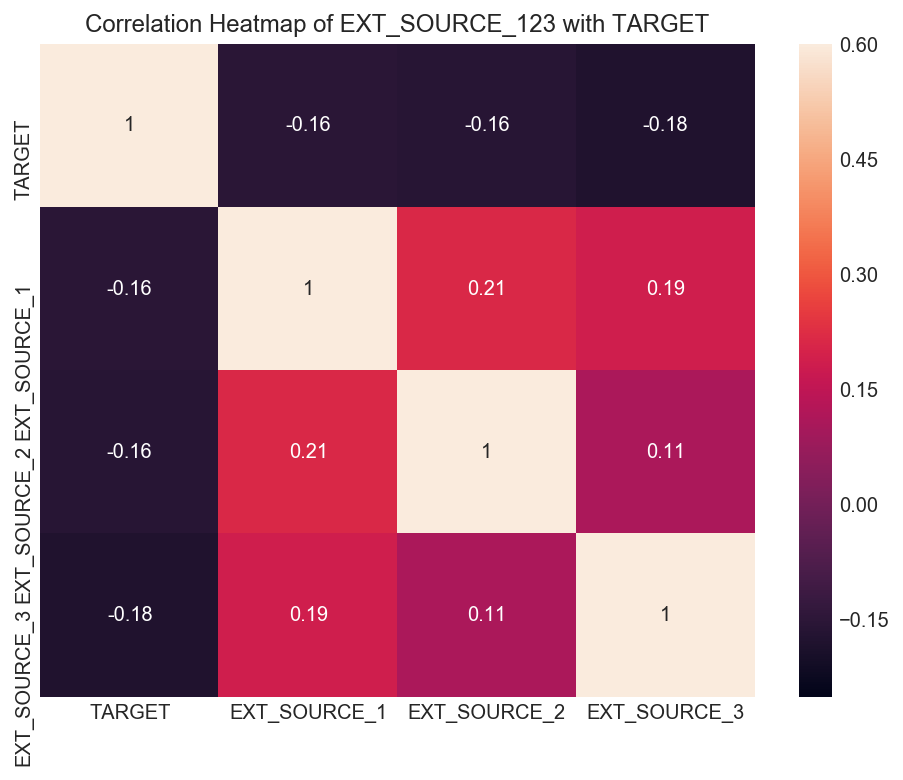

In [66]:
# Heatmap of correlations

plt.figure(figsize = (8, 6))

sns.heatmap(ext_source_df_corrs, vmin = -0.25, annot = True, vmax = 0.6) # can add 'cmap = plt.cm.RdYlBu_r' to change color
plt.title('Correlation Heatmap of EXT_SOURCE_123 with TARGET');

** Observation**

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. 

TARGET             0      1
EXT_SOURCE_1  124077  10054
EXT_SOURCE_2  282074  24773
EXT_SOURCE_3  227394  19148


Text(0.5,1,'EXT_SOURCE_123 with Target Vriable')

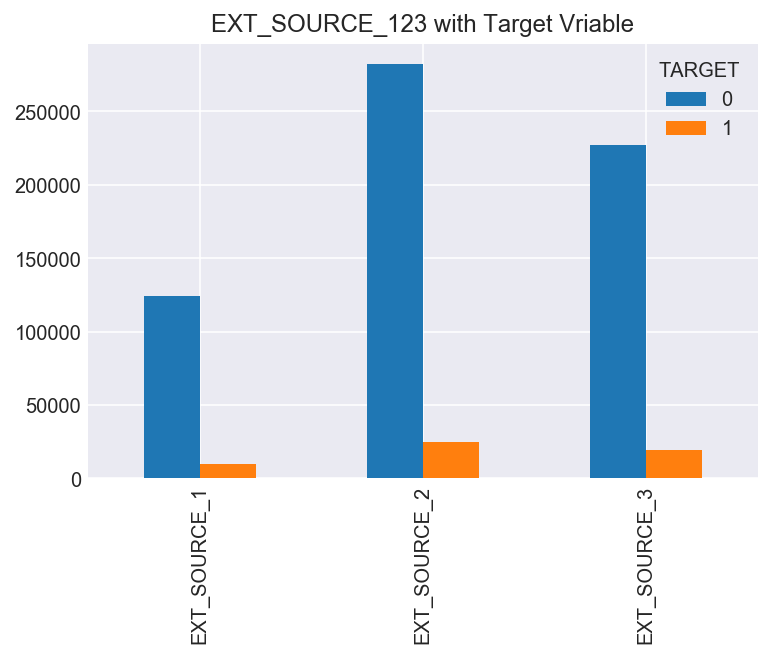

In [94]:
# Plotting a bar graph of these features by the value of Target variable

ext_source_df_agg = ext_source_df.groupby('TARGET').count()
#ext_source_df_agg.unstack()
ext_source_df_agg_T = ext_source_df_agg.transpose()
print(ext_source_df_agg_T)

ext_source_df_agg_T.plot(kind="bar", width=0.5)
plt.title('EXT_SOURCE_123 with Target Vriable')

### Exploring Other Features with Target varibale

In [4]:
#app_train_raw = pd.read_csv('./datasets/application_train.csv')

**Distribution for Total Amount of Income > 2500000**

C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


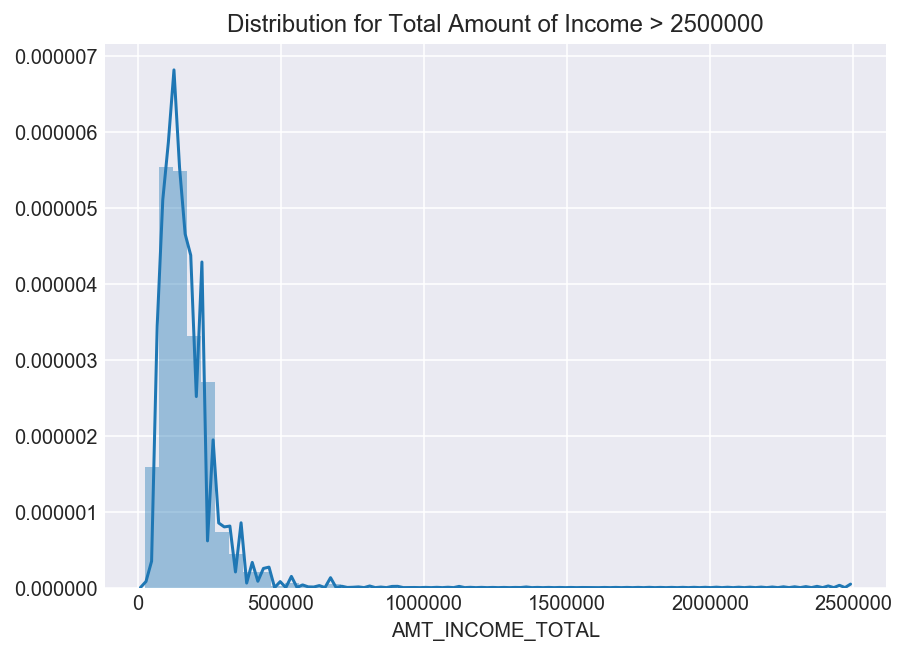

In [4]:
plt.figure(figsize=(7,5))
sns.distplot(app_train.loc[app_train['AMT_INCOME_TOTAL'] < 0.25e7, 'AMT_INCOME_TOTAL'].dropna())
plt.title("Distribution for Total Amount of Income > 2500000")
plt.show()

**Distribution of Credit Amount**

The 'AMT_CREDIT' feature describes the credit amount of the loan. 

C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


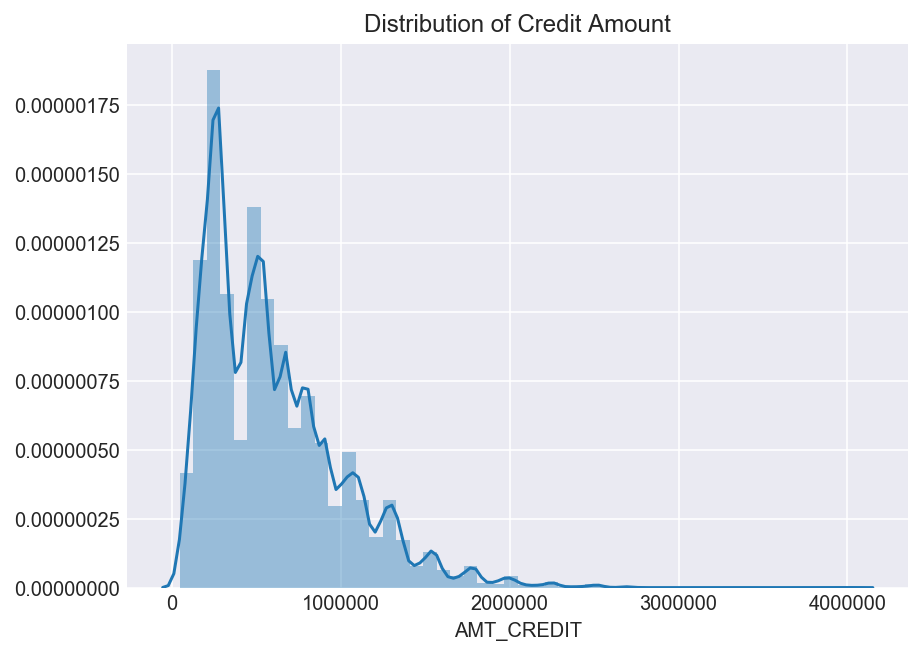

In [5]:
plt.figure(figsize=(7,5))
sns.distplot(app_train['AMT_CREDIT'].dropna())
plt.title("Distribution of Credit Amount")
plt.show()

**Distribution of Amount of Credit by Target Value**

As can be seen in the plot below, the distribution of repair and not repaid loans follow a similar distribution. Certain brackets of loans, for instance the range of loans between 400,000 and 600,000 have a higher ration of not repaid loans.

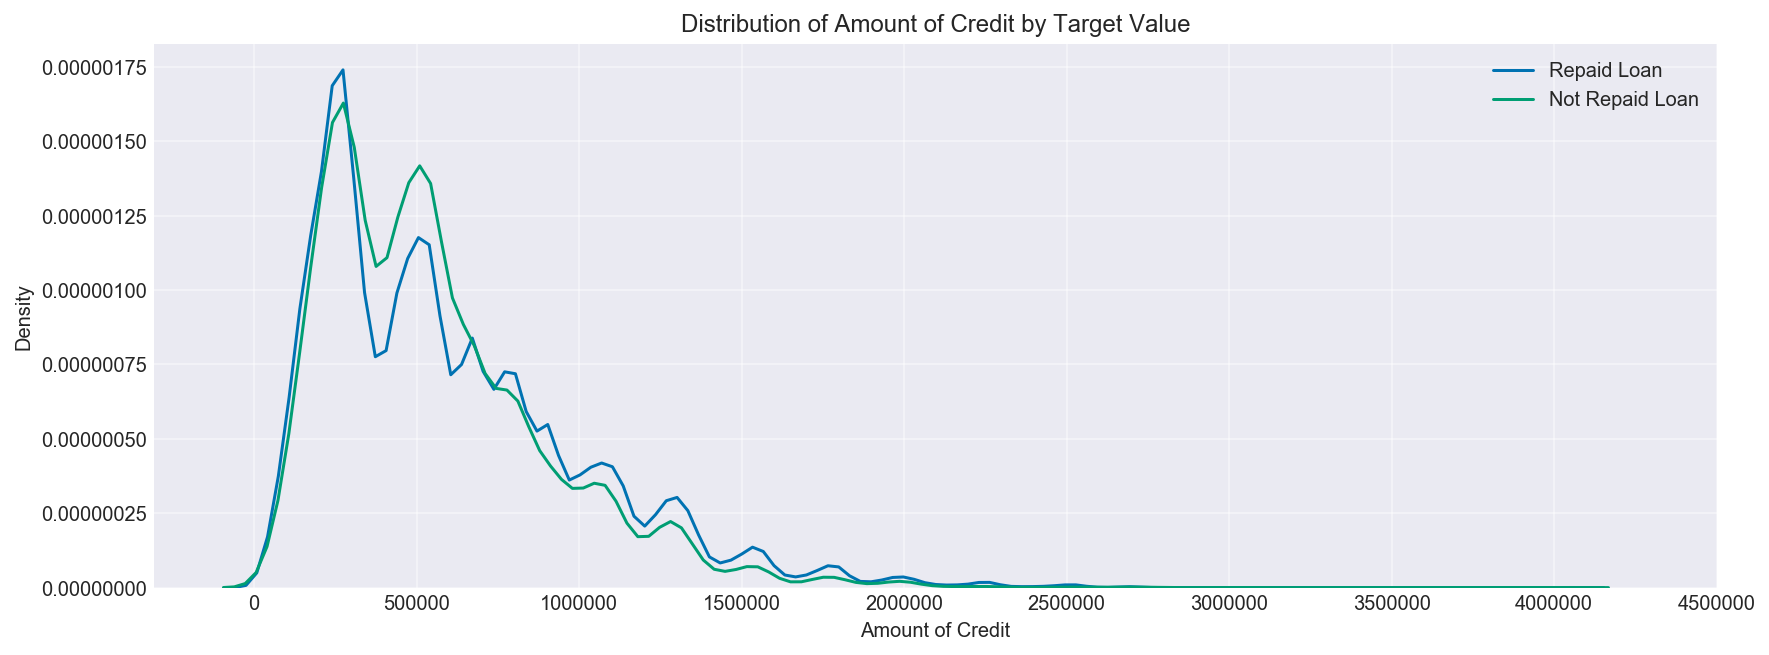

In [12]:
plt.figure(figsize=(14,5))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_CREDIT'], 
            label = 'Repaid Loan')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_CREDIT'], 
            label = 'Not Repaid Loan')
plt.xlabel('Amount of Credit')
plt.xticks(np.arange(0, 5000000, 500000))
plt.ylabel('Density')
plt.title('Distribution of Amount of Credit by Target Value');

#### Number of children of client vs AMT_CREDIT

In [128]:
app_train_raw.CNT_CHILDREN.unique()

array([ 0,  1,  2,  3,  4,  7,  5,  6,  8,  9, 11, 12, 10, 19, 14],
      dtype=int64)

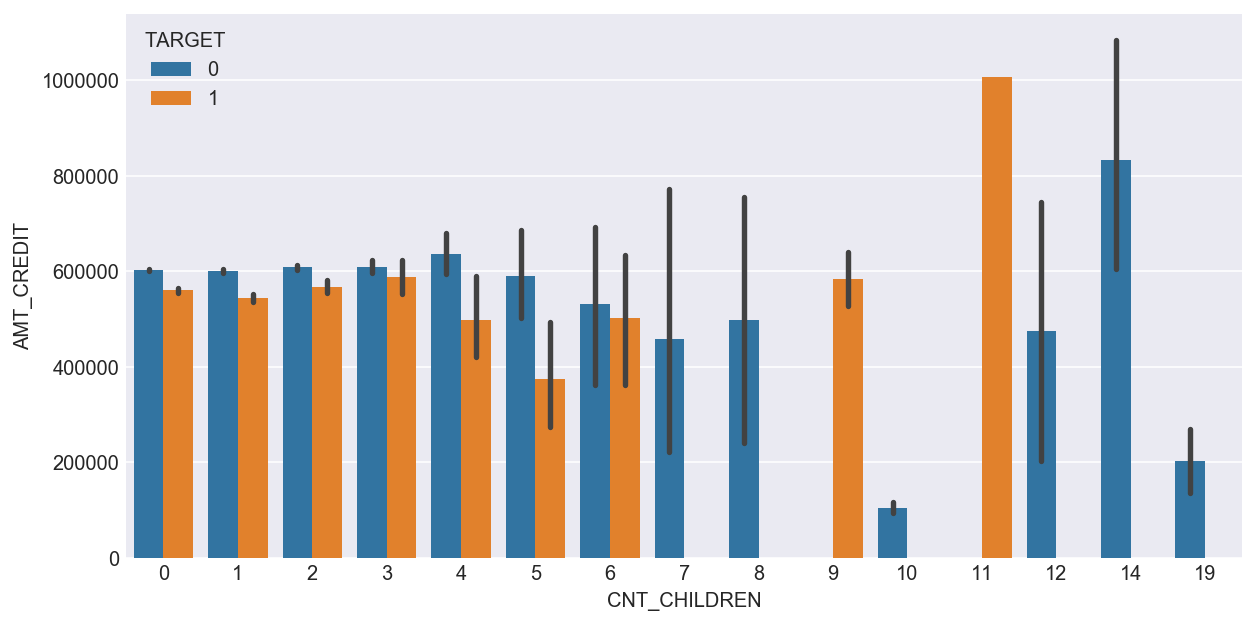

In [133]:
plt.figure(figsize= (10, 5))

sns.barplot(x="CNT_CHILDREN", y="AMT_CREDIT", hue="TARGET", data=app_train_raw)

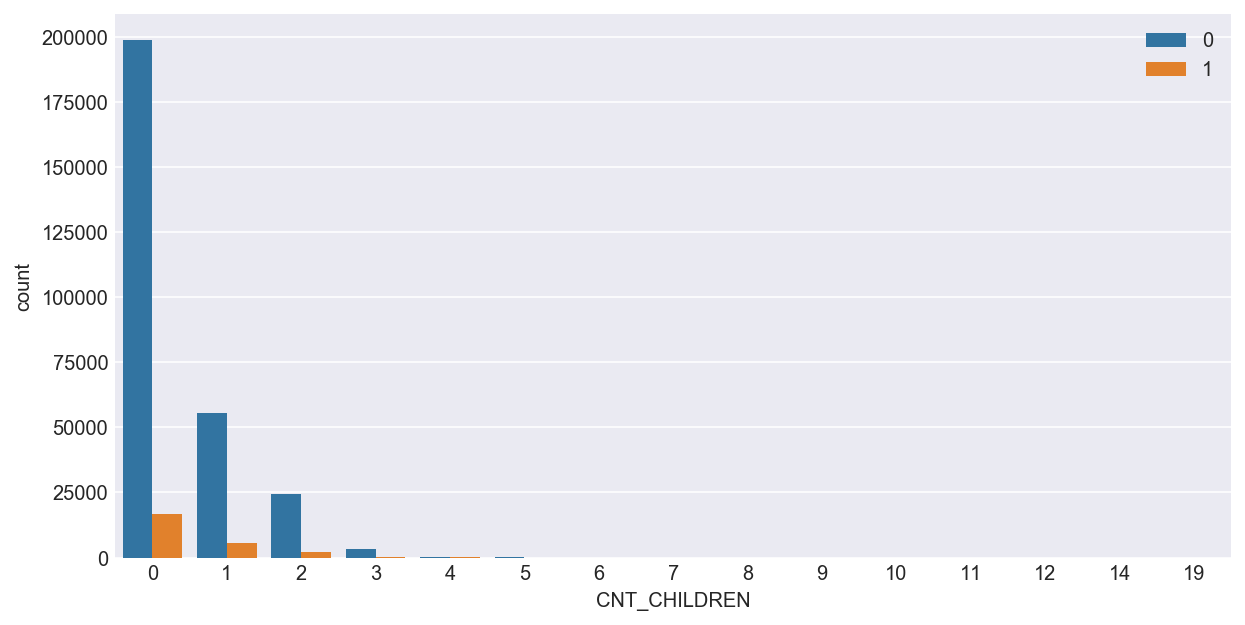

In [145]:
# number of children in term of repaid or not

plt.figure(figsize= (10,5))

sns.countplot(x="CNT_CHILDREN", hue="TARGET", data=app_train_raw, )
plt.legend(loc='upper right')

#### Number of family member of client

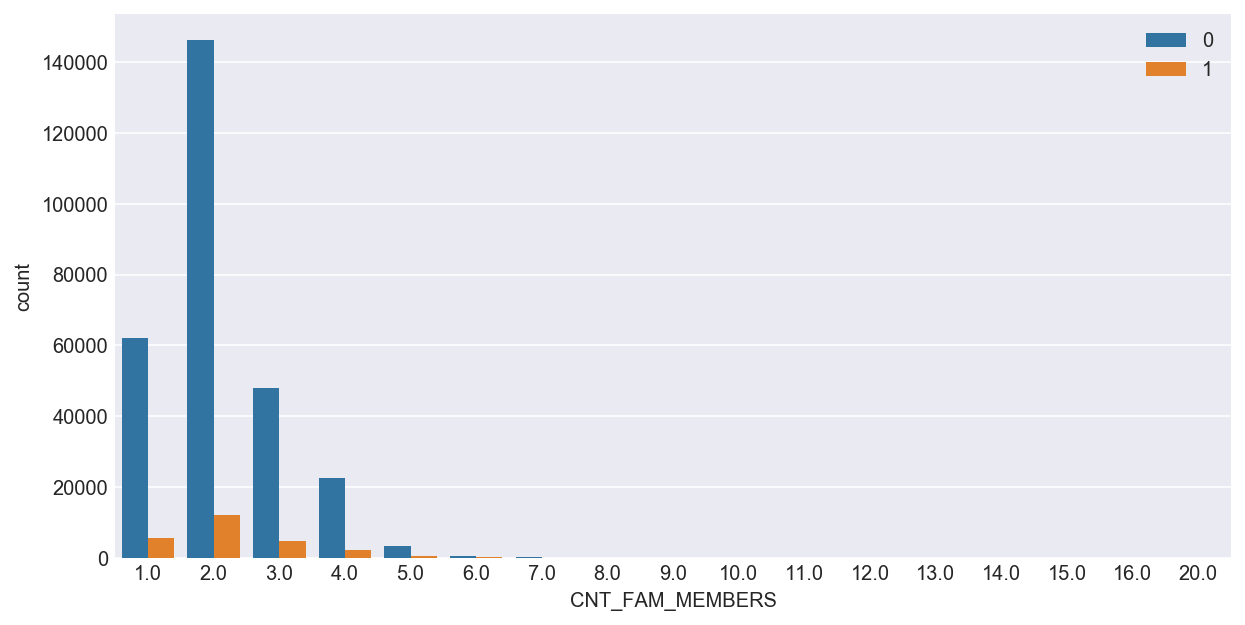

In [144]:
# Number of family member of client in term of repaid or not

plt.figure(figsize= (10, 5))


sns.countplot(x="CNT_FAM_MEMBERS", hue="TARGET", data=app_train_raw)
plt.legend(loc='upper right')

#### Family status of client

                      TARGET
NAME_FAMILY_STATUS          
Civil marriage         29775
Married               196432
Separated              19770
Single / not married   45444
Unknown                    2
Widow                  16088


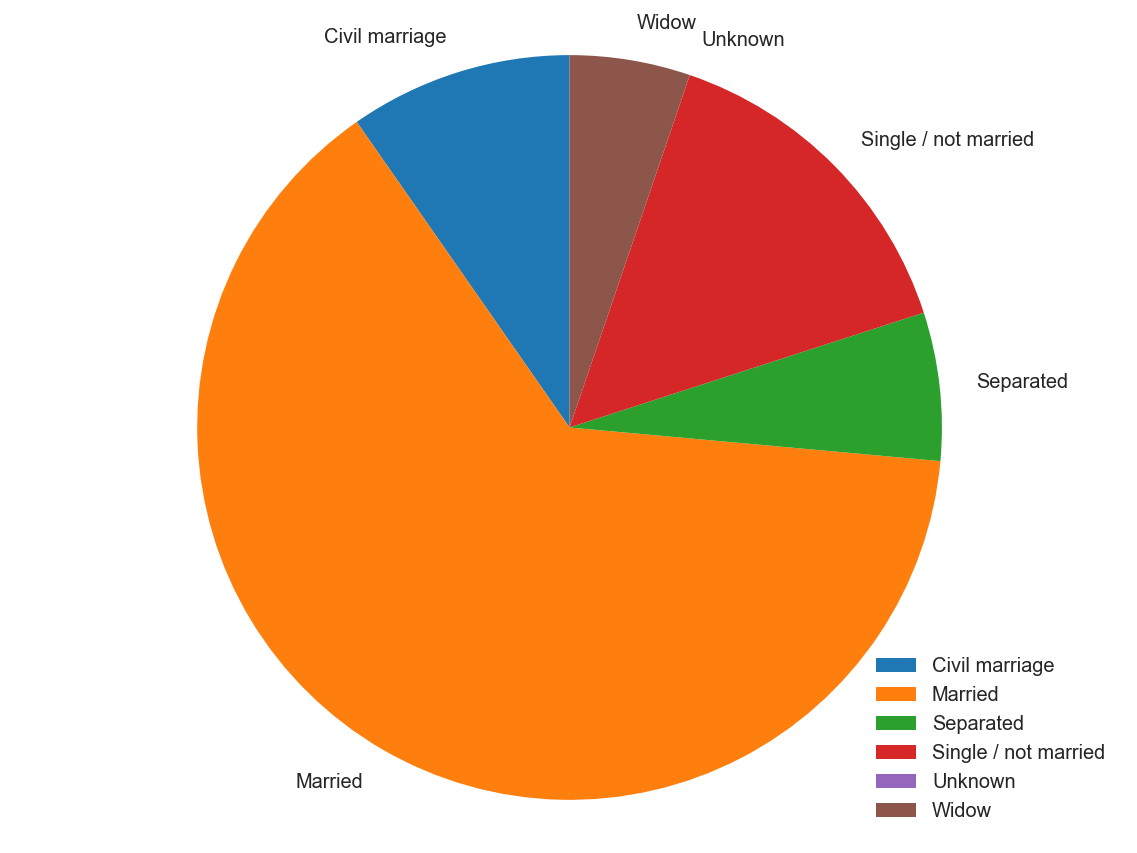

In [43]:
# pie chart of clients' family status
plt.figure(figsize=(8, 6))

# calculate propotion of clients' family status
family_stt_df = app_train_raw.loc[:,['NAME_FAMILY_STATUS','TARGET']]
family_stt_df_agg = family_stt_df.groupby('NAME_FAMILY_STATUS').count()
print(family_stt_df_agg)

labels = family_stt_df_agg.index
sizes =  family_stt_df_agg.TARGET

plt.pie(sizes , labels=labels, startangle=90) # autopct='%1.1f%%'
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.tight_layout()
plt.show()



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

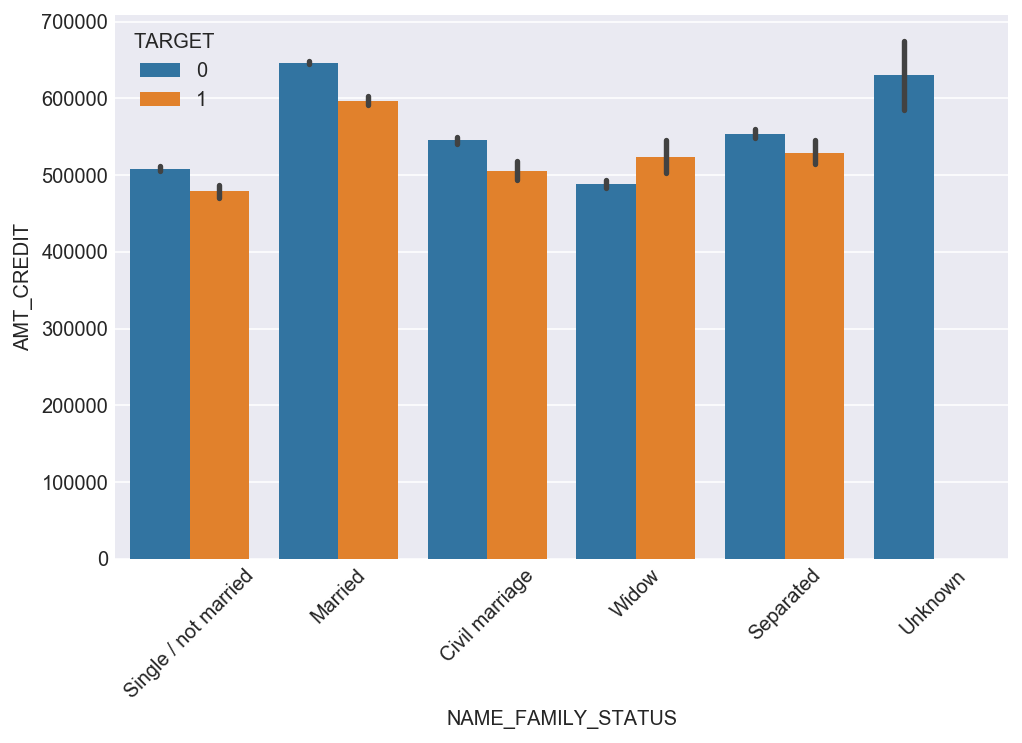

In [49]:
# Family status of the clients with credit amount of the loan (AMT_CREDIT) in term of Target variable

plt.figure(figsize= (8, 5))

sns.barplot(x= "NAME_FAMILY_STATUS", y="AMT_CREDIT", hue= "TARGET", data = app_train_raw)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

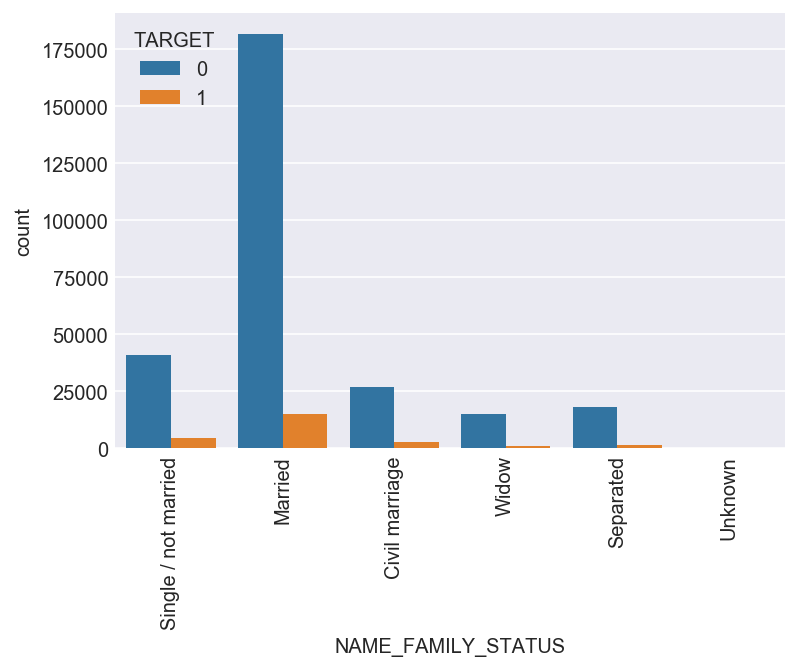

In [50]:
# client's family status in term of repaid or not

sns.countplot(x='NAME_FAMILY_STATUS', hue="TARGET", data=app_train_raw)
plt.xticks(rotation=90)

#### Education of client

In [114]:
# Education of clients
app_train_raw.NAME_EDUCATION_TYPE.unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

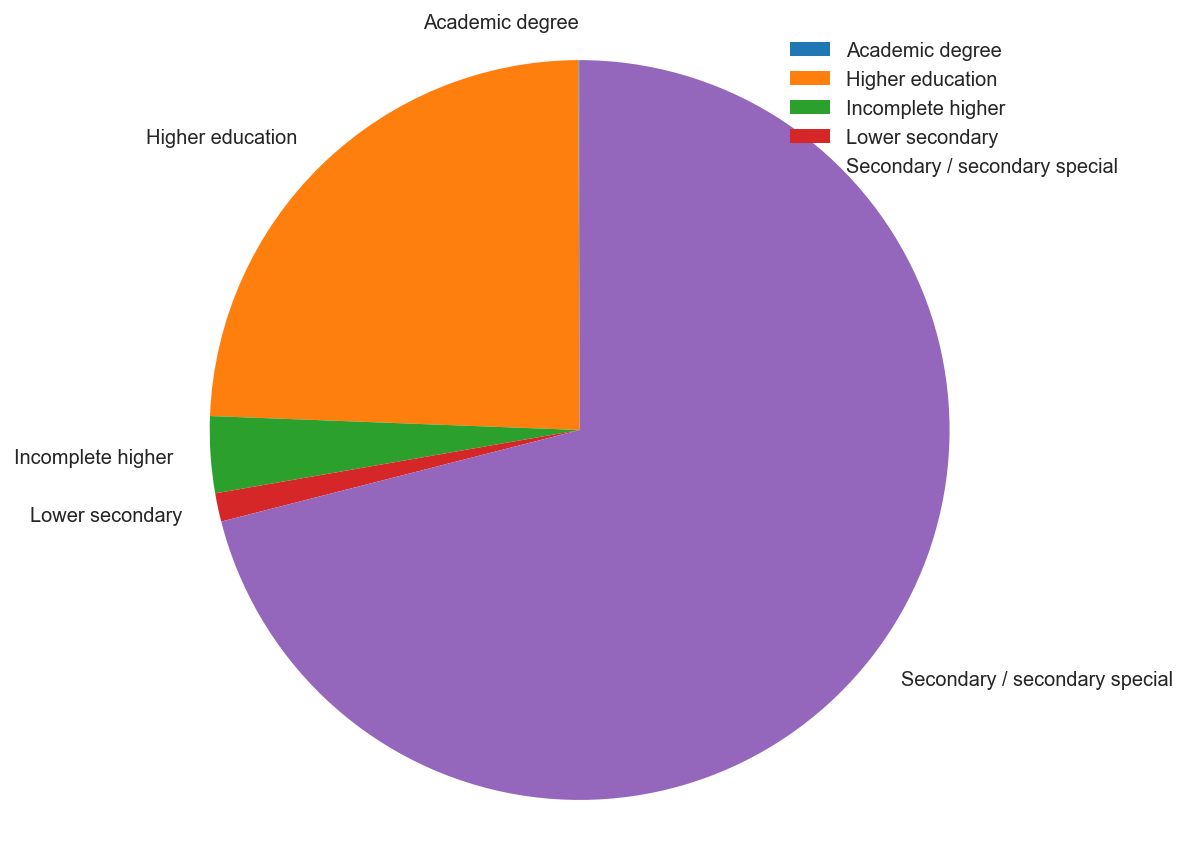

In [116]:
plt.figure(figsize=(8,6))

# pie chart of  propotion of each education type
edu_df = app_train_raw.loc[:,['NAME_EDUCATION_TYPE','TARGET']]
edu_df_agg = edu_df.groupby('NAME_EDUCATION_TYPE').count()


labels = edu_df_agg.index
sizes =  edu_df_agg.TARGET

plt.pie(sizes , labels=labels, startangle=90)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

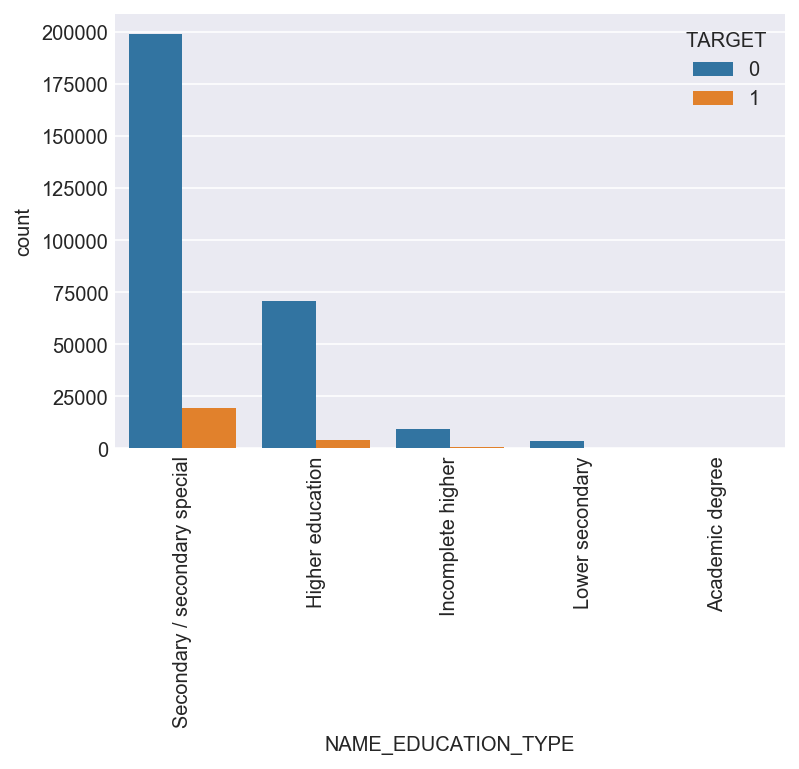

In [146]:
# Client's education in term of repaid or not
sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=app_train_raw)
plt.xticks(rotation=90)

### Contract type

The feature 'NAME_CONTRACT_TYPE' identifies if loan is cash or revolving.

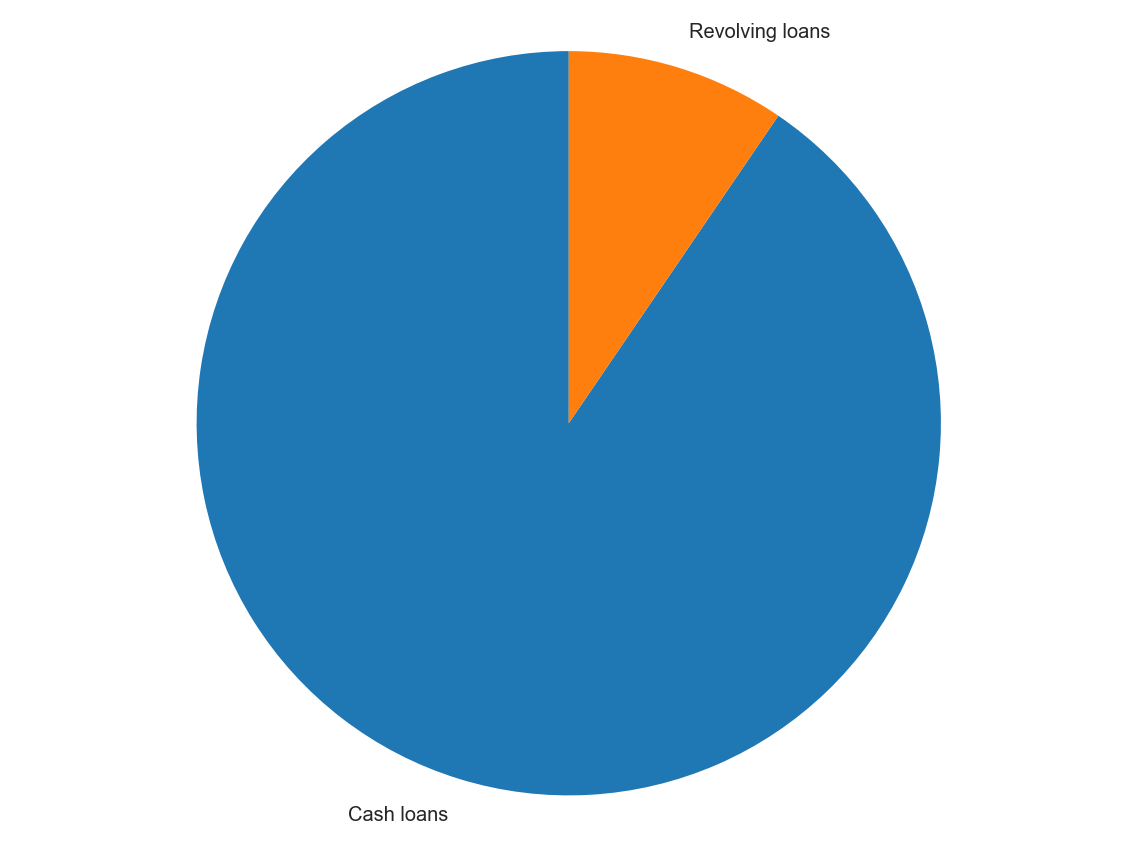

In [117]:
# pie chart of the propotion of contract type
plt.figure(figsize=(8,6))

# calculate propotion of each education type
contract_df = app_train_raw.loc[:,['NAME_CONTRACT_TYPE','TARGET']]
contract_agg = contract_df.groupby('NAME_CONTRACT_TYPE').count()


labels = contract_agg.index
sizes =  contract_agg.TARGET

plt.pie(sizes , labels=labels, startangle=90)
#plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()


(array([0, 1]), <a list of 2 Text xticklabel objects>)

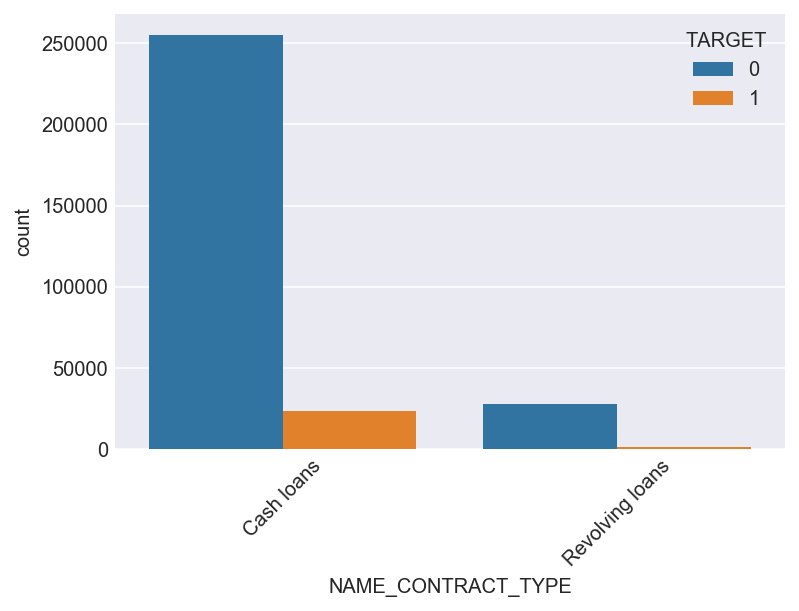

In [147]:
# contract type in term of repaid or not

sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=app_train_raw)
plt.xticks(rotation=45)

#### Income type of client

In [24]:
app_train_raw.NAME_INCOME_TYPE.unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

                      TARGET
NAME_INCOME_TYPE            
Businessman               10
Commercial associate   71617
Maternity leave            5
Pensioner              55362
State servant          21703
Student                   18
Unemployed                22
Working               158774


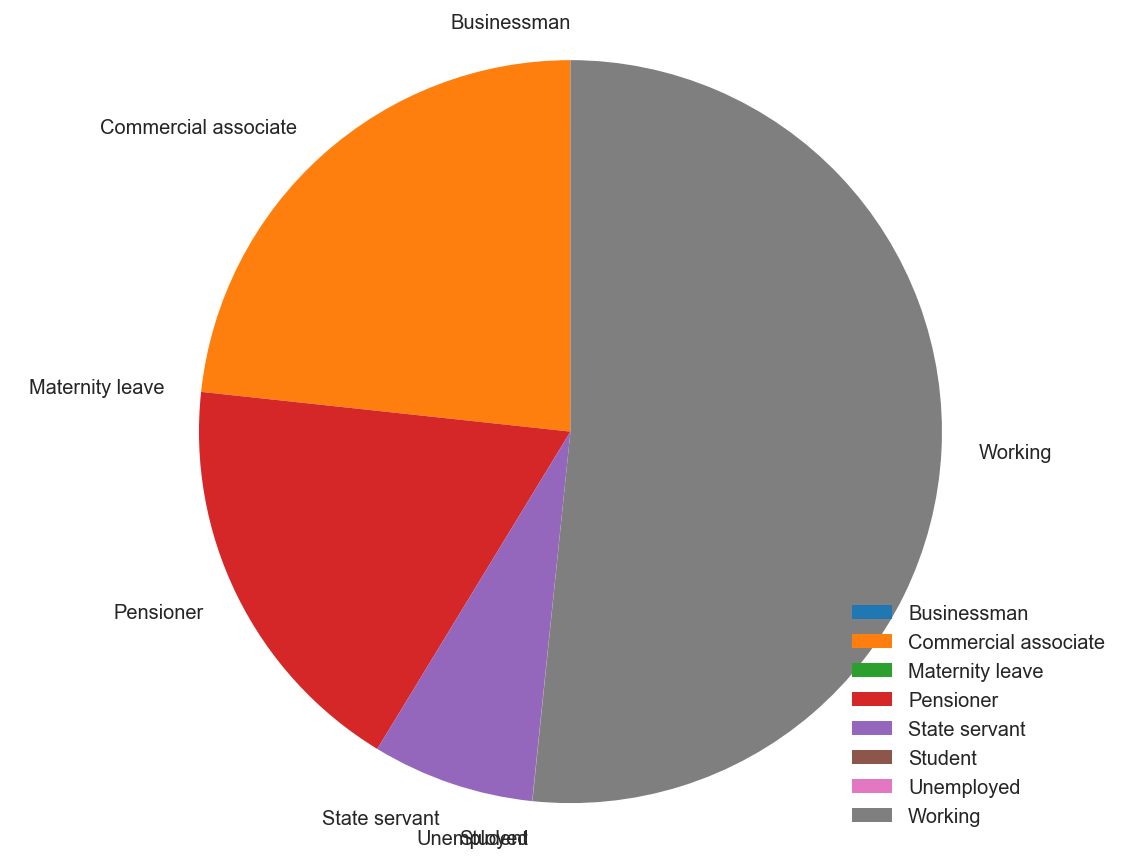

In [42]:
# pie chart of type of income of clients
plt.figure(figsize=(8, 6))

# calculate propotion of each education type
income_type_df = app_train_raw.loc[:,['NAME_INCOME_TYPE','TARGET']]
income_type_df_agg = income_type_df.groupby('NAME_INCOME_TYPE').count()
print(income_type_df_agg)

labels = income_type_df_agg.index
sizes =  income_type_df_agg.TARGET

plt.pie(sizes , labels=labels, startangle=90) # autopct='%1.1f%%'
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.tight_layout()
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

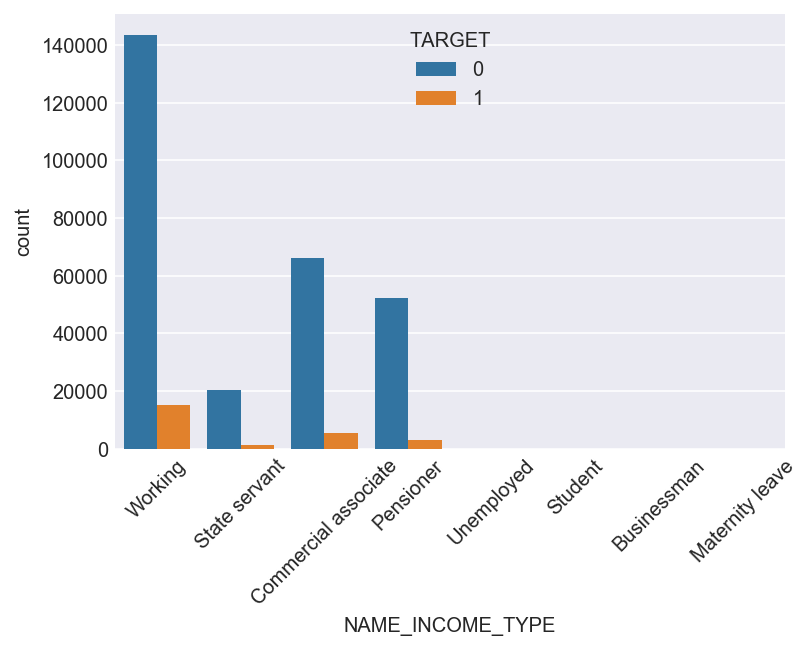

In [53]:
# clients' type of income in term of loan repaid or not

sns.countplot(x="NAME_INCOME_TYPE", hue="TARGET", data=app_train_raw)
plt.xticks(rotation=45)

#### Occupation type

Text(0,0.5,'Count')

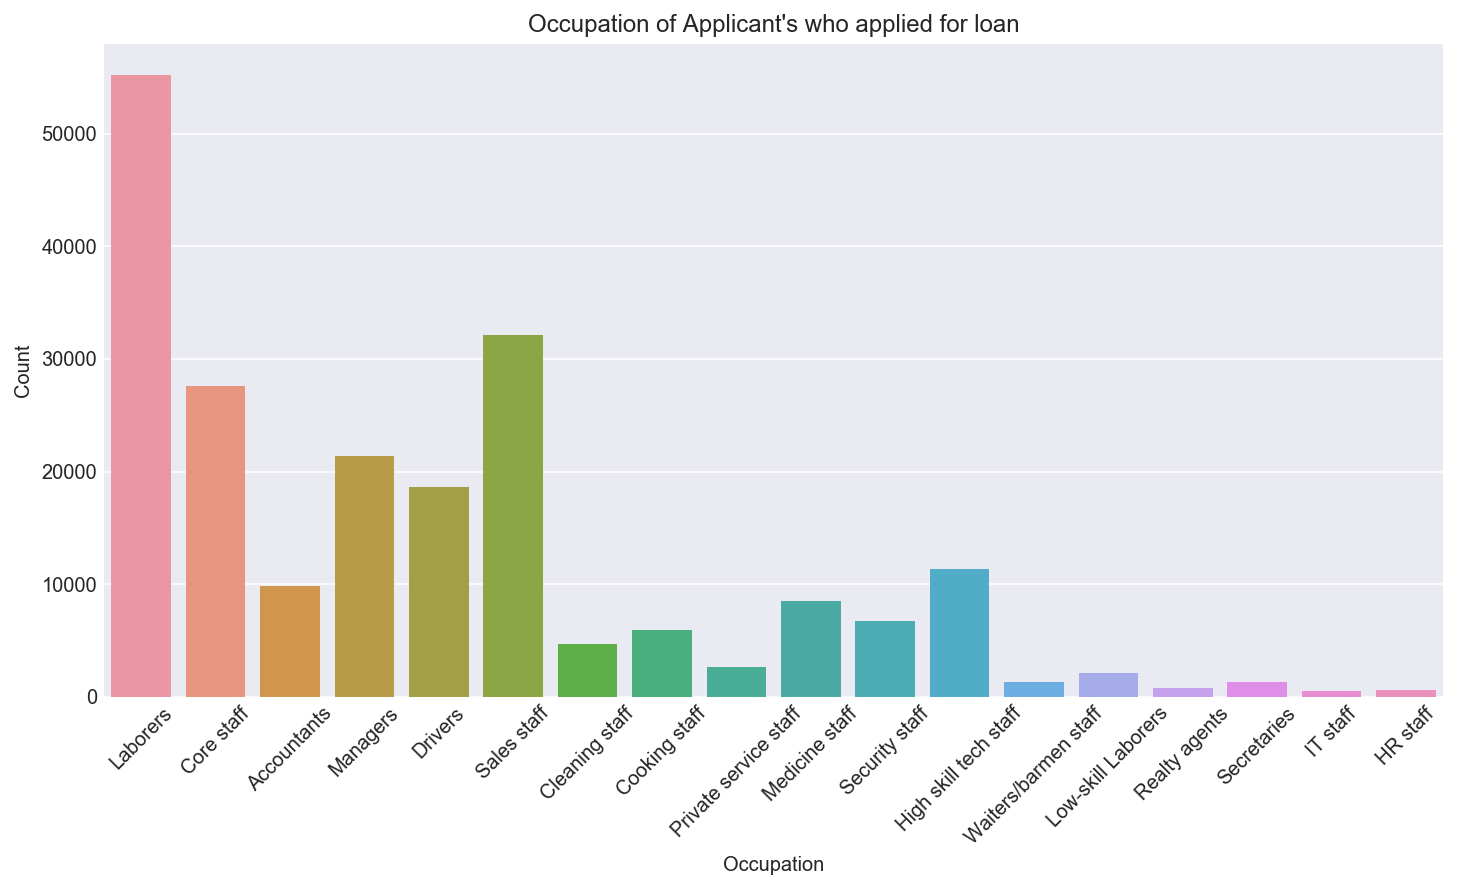

In [48]:
# Clients' occupation
plt.figure(figsize= (12,6))

sns.countplot(x="OCCUPATION_TYPE", data=app_train_raw)
plt.xticks(rotation=45)
plt.title('Occupation of Applicant\'s who applied for loan')
plt.xlabel('Occupation')
plt.ylabel('Count')


Interestingly, we see that laborers are by far the biggest users of loans, and also have the greatest variance in incomes! Not unexpected, but the average loan amounts seem fairly consistent. 

There are roughly two “types” of distributions:

- Tight with long tails (accountants, cleaning staff, managers)
- Wide with not much of a tail (realty agents, low skill labor)

Text(0,0.5,'Count')

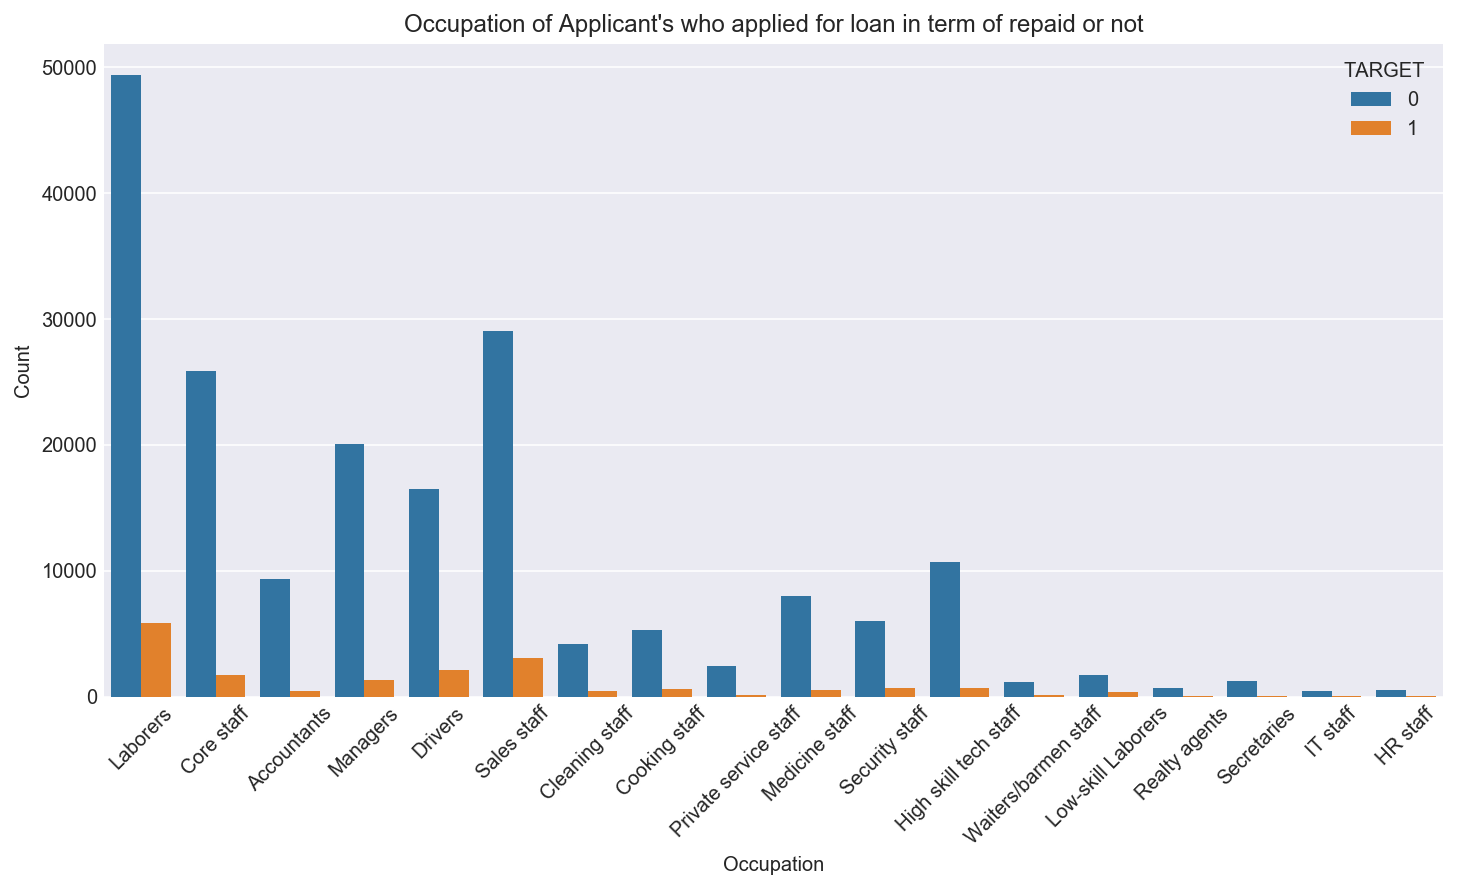

In [55]:
# Occupation type in term of loan repaid or not

plt.figure(figsize= (12,6))

sns.countplot(x="OCCUPATION_TYPE", hue="TARGET", data=app_train_raw)
plt.xticks(rotation=45)
plt.title('Occupation of Applicant\'s who applied for loan in term of repaid or not')
plt.xlabel('Occupation')
plt.ylabel('Count')

Now we can look at the distribution of income across different job types

#### Occupation vs Income/Credit

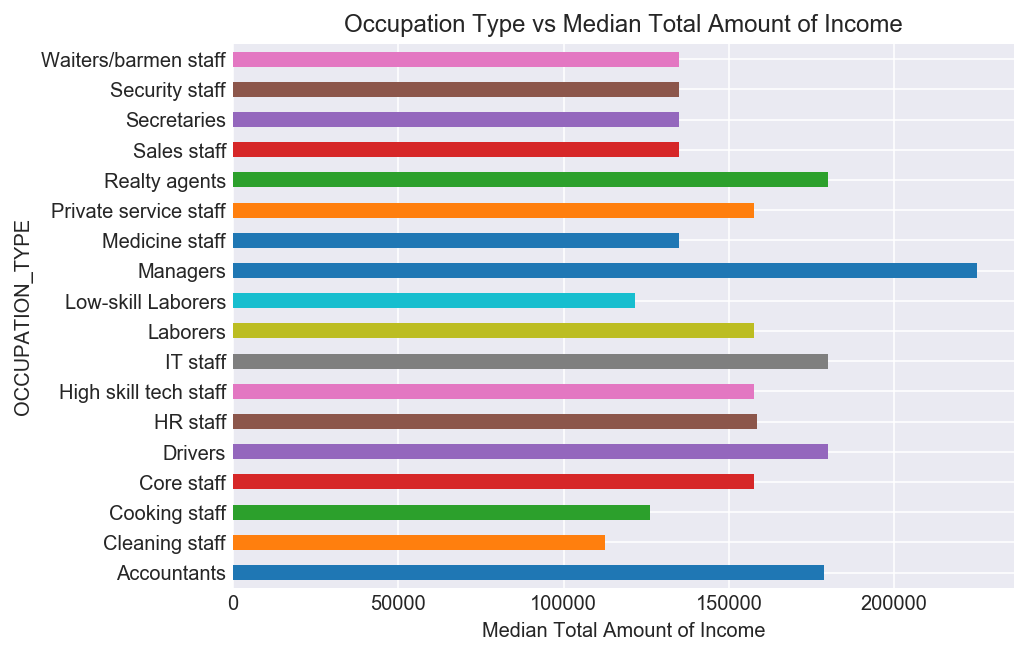

In [31]:
app_train.groupby(['OCCUPATION_TYPE'])['AMT_INCOME_TOTAL'].median().plot(kind='barh', figsize=(7,5))
plt.xlabel("Median Total Amount of Income")
plt.title("Occupation Type vs Median Total Amount of Income")
plt.show()

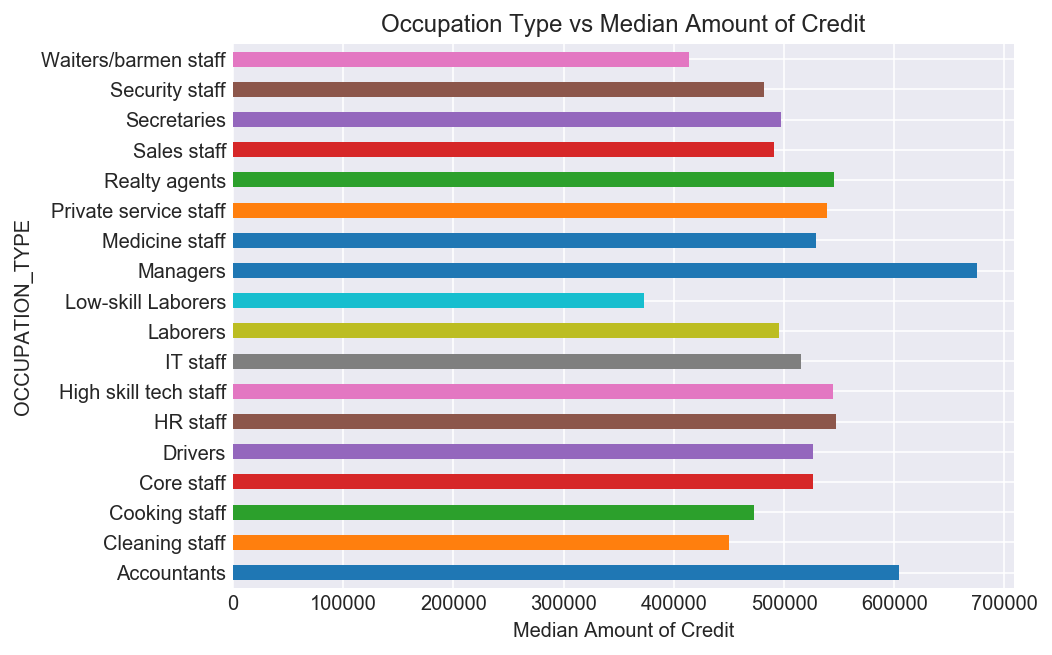

In [32]:
app_train.groupby(['OCCUPATION_TYPE'])['AMT_CREDIT'].median().plot(kind='barh', figsize=(7,5))
plt.xlabel("Median Amount of Credit")
plt.title("Occupation Type vs Median Amount of Credit")
plt.show()

C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib

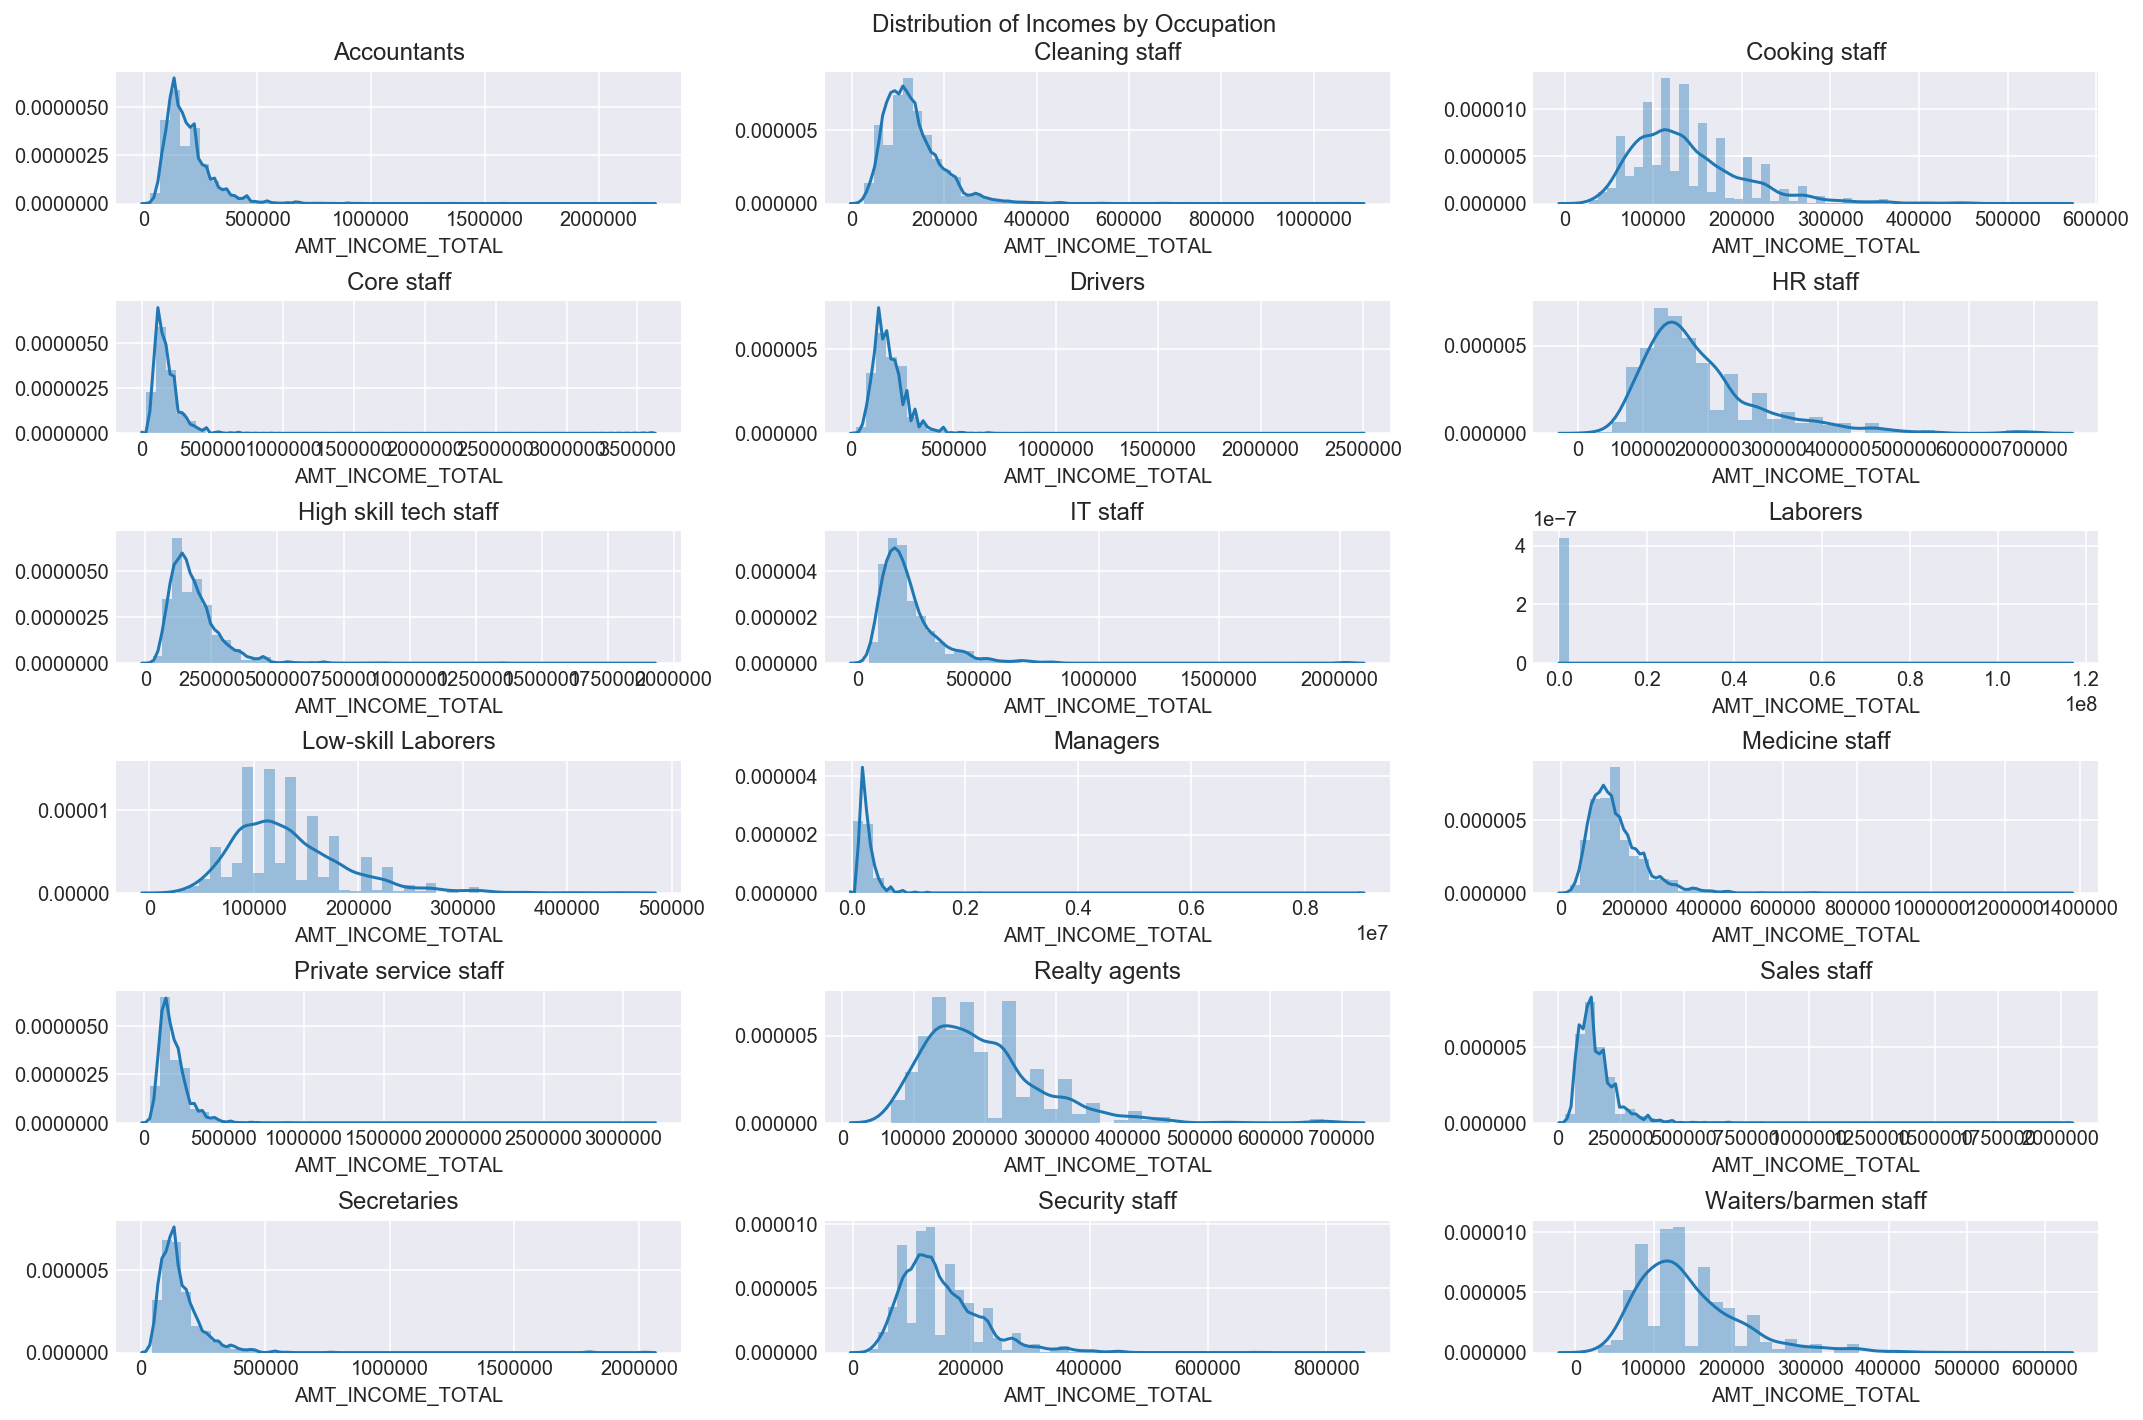

In [34]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,10))
plt.suptitle('Distribution of Incomes by Occupation')
j = 0
for i in np.unique(app_train['OCCUPATION_TYPE'].dropna()):
    sns.distplot(app_train.loc[app_train['OCCUPATION_TYPE']==i, 'AMT_INCOME_TOTAL'], ax=axes.flat[j])
    axes.flat[j].set_title(i)
    j += 1
    
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib

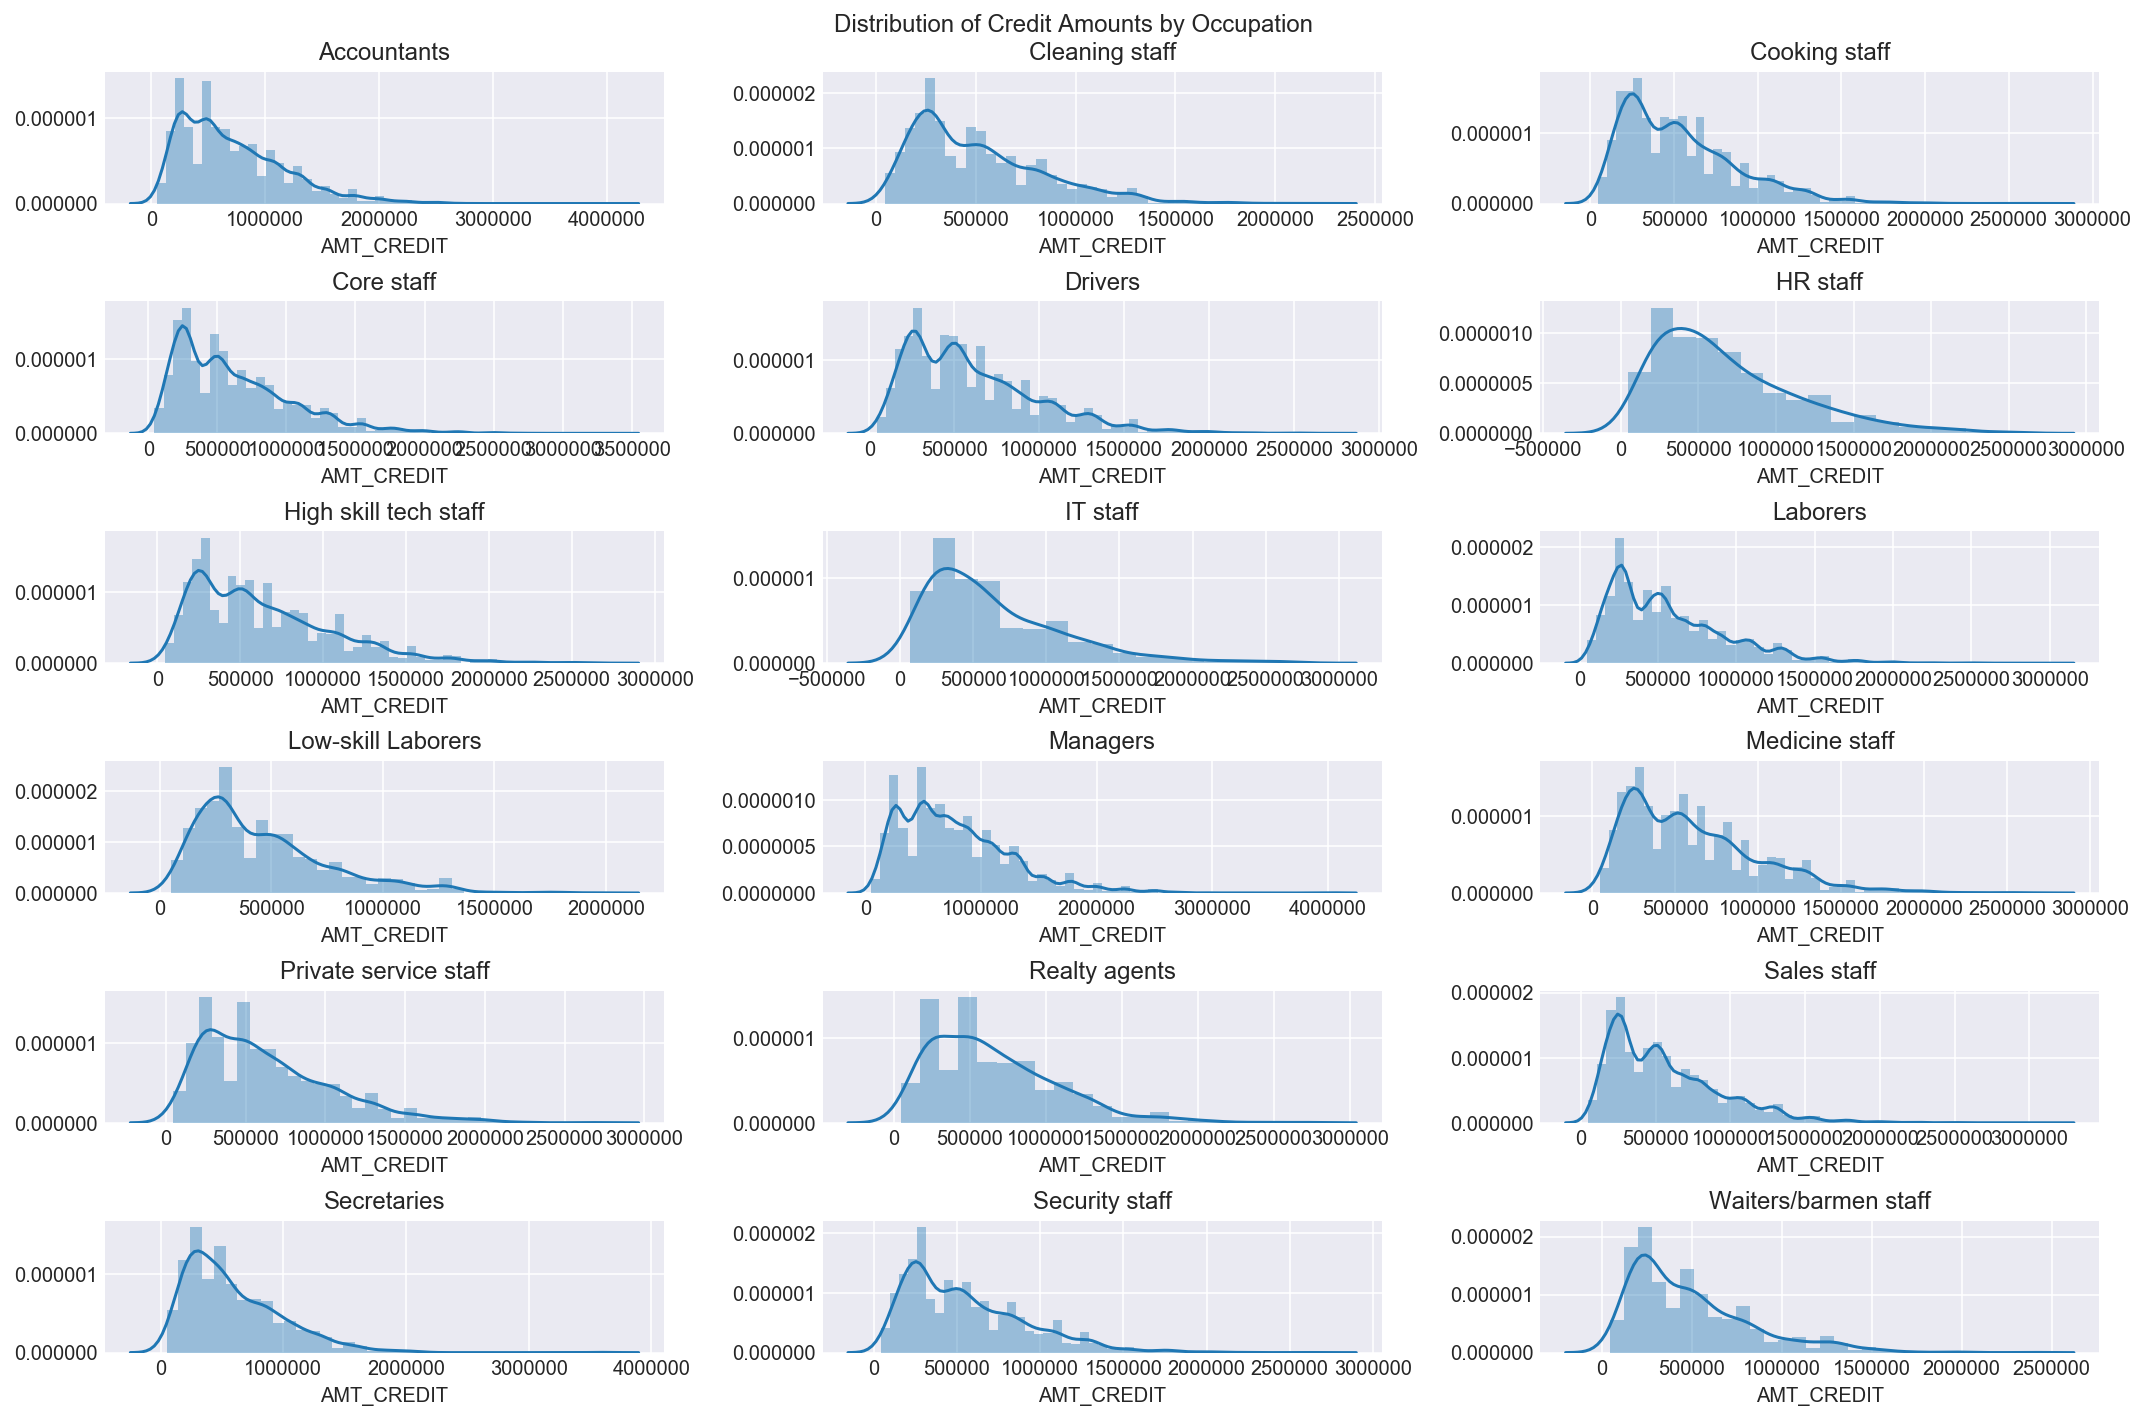

In [36]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,10))
plt.suptitle('Distribution of Credit Amounts by Occupation')
j = 0
for i in np.unique(app_train['OCCUPATION_TYPE'].dropna()):
    sns.distplot(app_train.loc[app_train['OCCUPATION_TYPE']==i, 'AMT_CREDIT'], ax=axes.flat[j])
    axes.flat[j].set_title(i)
    j += 1
    
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

### Making new features and aggregation on some existing features:

In [76]:
# Table: Application_train

income_by_org = app_train[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

app_train['CREDIT_INCOME_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_RATIO'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_DAYS_BIRTH_RATIO'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

app_train['CREDIT_GOODS_PRICES_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_train['INC_PER_CHLD'] = app_train['AMT_INCOME_TOTAL'] / (1 + app_train['CNT_CHILDREN'])
app_train['INC_BY_ORG'] = app_train['ORGANIZATION_TYPE'].map(income_by_org)
app_train['NEW_SOURCES_PROD'] = app_train['EXT_SOURCE_1'] * app_train['EXT_SOURCE_2'] * app_train['EXT_SOURCE_3']
app_train['NEW_EXT_SOURCES_MEAN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_train['NEW_EXT_SOURCES_STD'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
app_train['NEW_EXT_SOURCES_STD'] = app_train['NEW_EXT_SOURCES_STD'].fillna(app_train['NEW_EXT_SOURCES_STD'].mean())


-------------------------------

## 1.2. Table:  previous_application

### Loading data

In [14]:
# 1.6m rows
prev = pd.read_csv('./datasets/previous_application.csv')
prev.shape

(1670214, 37)

### Missing values check

In [7]:
missing_values_table(prev)

There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


My strategy is to remove columns with more than 70% nan values (will be done in later part 'Feature Engineering')

### Anomalies

In [15]:
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

### Making new features and aggregation on some existing features:

In [16]:
# return: prev_agg

prev, prev_cat_cols = one_hot_encoder(prev, nan_as_category = True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERCENTAGE'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# Aggregation fucntions on numeric features
num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERCENTAGE': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
}

# Aggreagtion function on categorical features (only mean function)
prev_cat_aggregations = {}
for cat in prev_cat_cols:
    prev_cat_aggregations[cat] = ['mean']
        

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **prev_cat_aggregations})

In [17]:
prev_agg.shape

(338857, 186)

In [18]:
prev_agg.head(3)

AMT_ANNUITY            AMT_APPLICATION           AMT_CREDIT  \
                   max       mean             min      mean        min   
SK_ID_CURR                                                               
100001        3951.000   3951.000         24835.5   24835.5    23787.0   
100002        9251.775   9251.775        179055.0  179055.0   179055.0   
100003       98356.995  56553.990         68809.5  435436.5    68053.5   

                                APP_CREDIT_PERCENTAGE                      \
                  max      mean                   min       max      mean   
SK_ID_CURR                                                                  
100001        23787.0   23787.0              1.044079  1.044079  1.044079   
100002       179055.0  179055.0              1.000000  1.000000  1.000000   
100003      1035882.0  484191.0              0.868825  1.011109  0.949329   

                     ...           PRODUCT_COMBINATION_Cash X-Sell: middle  \
                     ...                                              mean   
SK_ID_CURR           ...                                                     
100001               ...                                               0.0   
100002               ...                                               0.0   
100003               ...                                               0.0   

           PRODUCT_COMBINATION_POS household with interest  \
                                                      mean   
SK_ID_CURR                                                   
100001                                            0.000000   
100002                                            0.000000   
100003                                            0.333333   

           PRODUCT_COMBINATION_POS household without interest  \
                                                         mean   
SK_ID_CURR                                                      
100001                                                    0.0   
100002                                                    0.0   
100003                                                    0.0   

           PRODUCT_COMBINATION_POS industry with interest  \
                                                     mean   
SK_ID_CURR                                                  
100001                                           0.000000   
100002                                           0.000000   
100003                                           0.333333   

           PRODUCT_COMBINATION_POS industry without interest  \
                                                        mean   
SK_ID_CURR                                                     
100001                                                   0.0   
100002                                                   0.0   
100003                                                   0.0   

           PRODUCT_COMBINATION_POS mobile with interest  \
                                                   mean   
SK_ID_CURR                                                
100001                                              1.0   
100002                                              0.0   
100003                                              0.0   

           PRODUCT_COMBINATION_POS mobile without interest  \
                                                      mean   
SK_ID_CURR                                                   
100001                                                 0.0   
100002                                                 0.0   
100003                                                 0.0   

           PRODUCT_COMBINATION_POS other with interest  \
                                                  mean   
SK_ID_CURR                                               
100001                                             0.0   
100002                                             1.0   
100003                                             0.0   

           PRODUCT_COMBINATION_POS others

In [19]:
prev_agg = prev_agg.reset_index()

In [20]:
prev_agg.head(3)

SK_ID_CURR AMT_ANNUITY            AMT_APPLICATION           AMT_CREDIT  \
                     max       mean             min      mean        min   
0     100001    3951.000   3951.000         24835.5   24835.5    23787.0   
1     100002    9251.775   9251.775        179055.0  179055.0   179055.0   
2     100003   98356.995  56553.990         68809.5  435436.5    68053.5   

                       APP_CREDIT_PERCENTAGE            \
         max      mean                   min       max   
0    23787.0   23787.0              1.044079  1.044079   
1   179055.0  179055.0              1.000000  1.000000   
2  1035882.0  484191.0              0.868825  1.011109   

            ...           PRODUCT_COMBINATION_Cash X-Sell: middle  \
            ...                                              mean   
0           ...                                               0.0   
1           ...                                               0.0   
2           ...                                               0.0   

  PRODUCT_COMBINATION_POS household with interest  \
                                             mean   
0                                        0.000000   
1                                        0.000000   
2                                        0.333333   

  PRODUCT_COMBINATION_POS household without interest  \
                                                mean   
0                                                0.0   
1                                                0.0   
2                                                0.0   

  PRODUCT_COMBINATION_POS industry with interest  \
                                            mean   
0                                       0.000000   
1                                       0.000000   
2                                       0.333333   

  PRODUCT_COMBINATION_POS industry without interest  \
                                               mean   
0                                               0.0   
1                                               0.0   
2                                               0.0   

  PRODUCT_COMBINATION_POS mobile with interest  \
                                          mean   
0                                          1.0   
1                                          0.0   
2                                          0.0   

  PRODUCT_COMBINATION_POS mobile without interest  \
                                             mean   
0                                             0.0   
1                                             0.0   
2                                             0.0   

  PRODUCT_COMBINATION_POS other with interest  \
                                         mean   
0                                         0.0   
1                                         1.0   
2                                         0.0   

  PRODUCT_COMBINATION_POS others without interest PRODUCT_COMBINATION_nan  
                                             mean                    mean  
0                                             0.0                     0.0  
1                                             0.0                     0.0  
2                                             0.0                     0.0  

[3 rows x 187 columns]

In [21]:
# rename cols
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [22]:
prev_agg.head(3)

,PREV_SK_ID_CURR_,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERCENTAGE_MIN,PREV_APP_CREDIT_PERCENTAGE_MAX,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
0,100001,3951.000,3951.000,24835.5,24835.5,23787.0,23787.0,23787.0,1.044079,1.044079,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,1.000000,1.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,100003,98356.995,56553.990,68809.5,435436.5,68053.5,1035882.0,484191.0,0.868825,1.011109,...,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# rename col which is primary key
prev_agg.rename(columns = {'PREV_SK_ID_CURR_':'SK_ID_CURR'}, inplace = True)

In [27]:
prev_agg.to_csv("prev_agg.csv")

------------------------------------------------------------

## 1.3 Table: bureau

### Loading data

In [25]:
import gc
gc.collect()

14

In [26]:
# 1.7m rows
bureau = pd.read_csv('./datasets/bureau.csv')
bureau.shape

(1716428, 17)

### Missing value check

In [27]:
missing_values_table(bureau)

There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


### Making new features and aggregation on some existing features:

In [28]:
# return bureau_agg

bureau, bureau_cat_cols = one_hot_encoder(bureau, nan_as_category = True)

# Aggregation functions on numeric features 
num_aggregations = {
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum']
}


#Aggregation on categorical features
cat_aggregations = {}
for cat in bureau_cat_cols: 
    cat_aggregations[cat] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

#bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


In [29]:
bureau_agg.shape

(305811, 42)

In [29]:
bureau_agg = bureau_agg.reset_index()

In [30]:
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [31]:
bureau_agg.head(3)

,BURO_SK_ID_CURR_,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,...,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN
0,100001,-735.00,240043.666667,82.428571,-93.142857,0.0,NaN,207623.571429,1453365.000,85240.928571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,-874.00,186150.000000,-349.000000,-499.875000,0.0,1681.029,108131.945625,865055.565,49156.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100003,-1400.75,827783.583333,-544.500000,-816.000000,0.0,0.000,254350.125000,1017400.500,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
bureau_agg.rename(columns = {'BURO_SK_ID_CURR_':'SK_ID_CURR'}, inplace = True)

In [33]:
bureau_agg.head(3)

,SK_ID_CURR,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,...,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN
0,100001,-735.00,240043.666667,82.428571,-93.142857,0.0,NaN,207623.571429,1453365.000,85240.928571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,-874.00,186150.000000,-349.000000,-499.875000,0.0,1681.029,108131.945625,865055.565,49156.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100003,-1400.75,827783.583333,-544.500000,-816.000000,0.0,0.000,254350.125000,1017400.500,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [35]:
bureau_agg.to_csv("bureau_agg.csv")

-------------------------

## 1.4 Table: INSTALLMENT_PAYMENTS

In [34]:
### Reading and pre-processing table INSTALLMENT_PAYMENTS (13.3m rows)

# this table does not have any categorical cols
payment = pd.DataFrame()

chunksize = 10 ** 6
for chunk in pd.read_csv('./datasets/installments_payments.csv', chunksize=chunksize):
    
    #chunk, payment_cat_cols = one_hot_encoder(chunk, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    chunk['payment_percentage'] = chunk['AMT_PAYMENT'] / chunk['AMT_INSTALMENT']
    chunk['payment_difference'] = chunk['AMT_INSTALMENT'] - chunk['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    chunk['days_past_due'] = chunk['DAYS_ENTRY_PAYMENT'] - chunk['DAYS_INSTALMENT']
    chunk['days_before_due'] = chunk['DAYS_INSTALMENT'] - chunk['DAYS_ENTRY_PAYMENT']
    chunk['days_past_due'] = chunk['days_past_due'].apply(lambda x: x if x > 0 else 0)
    chunk['days_before_due'] = chunk['days_before_due'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'days_past_due': ['max', 'mean', 'sum'],
        'days_before_due': ['max', 'mean', 'sum'],
        'payment_percentage': ['max', 'mean', 'sum', 'var'],
        'payment_difference': ['max', 'mean', 'sum', 'var'],
    }
    
    #for cat in payment_cat_cols:
        #aggregations[cat] = ['mean']
        
    temp = chunk.groupby('SK_ID_CURR').agg(aggregations)
    payment = payment.append(temp)

In [35]:
payment.shape

(1392097, 15)

In [36]:
payment.unstack()
payment = payment.reset_index()
payment.columns

MultiIndex(levels=[['NUM_INSTALMENT_VERSION', 'days_past_due', 'days_before_due', 'payment_percentage', 'payment_difference', 'SK_ID_CURR'], ['max', 'mean', 'nunique', 'sum', 'var', '']],
           labels=[[5, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4], [5, 2, 0, 1, 3, 0, 1, 3, 0, 1, 3, 4, 0, 1, 3, 4]])

In [37]:
payment.head(3)

SK_ID_CURR NUM_INSTALMENT_VERSION days_past_due           days_before_due  \
                            nunique           max mean  sum             max   
0     100002                      2           0.0  0.0  0.0            24.0   
1     100003                      1           0.0  0.0  0.0             9.0   
2     100005                      2           0.0  0.0  0.0            30.0   

                    payment_percentage                payment_difference       \
        mean    sum                max mean  sum  var                max mean   
0  18.500000  148.0                1.0  1.0  8.0  0.0                0.0  0.0   
1   5.000000   25.0                1.0  1.0  5.0  0.0                0.0  0.0   
2  21.333333   64.0                1.0  1.0  3.0  0.0                0.0  0.0   

             
   sum  var  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0

In [38]:
len(payment.SK_ID_CURR.unique())

#payment[payment.SK_ID_CURR == 100002] still have repeated rows for the same SK_ID_CURR

# flatten a hierarchical index in columns

cols = payment.columns
ind = pd.Index([e[0] + "_" + e[1] for e in cols.tolist()])
payment.columns = ind

aggregations = {
        'NUM_INSTALMENT_VERSION_nunique': ['nunique'],
        'days_past_due_max': ['max'],
        'days_past_due_mean': ['mean'],
        'days_past_due_sum' : ['sum'],
        'days_before_due_max': ['max'],
        'days_before_due_mean': ['mean'],
        'days_before_due_sum': ['sum'],
        'payment_percentage_max': ['max'],
        'payment_percentage_mean': ['mean'],
        'payment_percentage_sum': ['sum'],
        'payment_percentage_var': ['var'],
        'payment_difference_max': ['max'],
        'payment_difference_mean': ['mean'],
        'payment_difference_sum': ['sum'],
        'payment_difference_var': ['var']
}
payment = payment.groupby('SK_ID_CURR_').agg(aggregations)

payment = payment.reset_index()
payment.head(3)

,SK_ID_CURR_,NUM_INSTALMENT_VERSION_nunique,days_past_due_max,days_past_due_mean,days_past_due_sum,days_before_due_max,days_before_due_mean,days_before_due_sum,payment_percentage_max,payment_percentage_mean,payment_percentage_sum,payment_percentage_var,payment_difference_max,payment_difference_mean,payment_difference_sum,payment_difference_var
,,nunique,max,mean,sum,max,mean,sum,max,mean,sum,var,max,mean,sum,var
0,100001,2,11.0,1.222222,11.0,36.0,9.722222,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0
1,100002,2,0.0,0.000000,0.0,31.0,21.400000,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0
2,100003,2,0.0,0.000000,0.0,14.0,7.262821,179.0,1.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# flatten a hierarchical index in columns

cols2 = payment.columns

ind2 = pd.Index([e[0] for e in cols2.tolist()])
payment.columns = ind2
payment.rename(columns = {'SK_ID_CURR_':'SK_ID_CURR'}, inplace = True)

print(len(payment.SK_ID_CURR.unique()))
print(payment.shape)
payment.head(3)

339587
(339587, 16)


,SK_ID_CURR,NUM_INSTALMENT_VERSION_nunique,days_past_due_max,days_past_due_mean,days_past_due_sum,days_before_due_max,days_before_due_mean,days_before_due_sum,payment_percentage_max,payment_percentage_mean,payment_percentage_sum,payment_percentage_var,payment_difference_max,payment_difference_mean,payment_difference_sum,payment_difference_var
0,100001,2,11.0,1.222222,11.0,36.0,9.722222,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0
1,100002,2,0.0,0.000000,0.0,31.0,21.400000,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0
2,100003,2,0.0,0.000000,0.0,14.0,7.262821,179.0,1.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
payment.to_csv('payment.csv')

----------------------------

## 1.5 Table: POS_CASH_BALANCE

In [11]:
pos = pd.DataFrame()

chunksize = 10 ** 6
for chunk in pd.read_csv('./datasets/POS_CASH_balance.csv', chunksize=chunksize):
    # chunk, categorical_cols = one_hot_encoder(chunk, nan_as_category= True)
    # Numeric features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    # Categorical feartures
    # for cat in categorical_cols :
        # aggregations[cat] = ['mean']
    
    pos_agg = chunk.groupby('SK_ID_CURR').agg(aggregations)
    pos = pos.append(pos_agg)


In [12]:
pos.shape

(2623091, 7)

In [13]:
pos = pos.reset_index()

print(len(pos.SK_ID_CURR.unique()))

# flatten a hierarchical index in columns

cols_pos = pos.columns
ind_pos = pd.Index([e[0] + "_" + e[1] for e in cols_pos.tolist()])
pos.columns = ind_pos

aggregations_pos = {
    'MONTHS_BALANCE_max':['max'],
    'MONTHS_BALANCE_mean':['mean'],
    'MONTHS_BALANCE_size':['size'],
    'SK_DPD_max':['max'],
    'SK_DPD_max':['mean'],
    'SK_DPD_DEF_max':['max'],
    'SK_DPD_DEF_mean':['mean'],
}

pos = pos.groupby('SK_ID_CURR_').agg(aggregations_pos)
pos = pos.reset_index()

# rename cols in pos
cols_pos_2 = pos.columns
ind_pos_2 = pd.Index([e[0] for e in cols_pos_2.tolist()])
pos.columns = ind_pos_2

pos.rename(columns = {'SK_ID_CURR_':'SK_ID_CURR'}, inplace = True)

337252


In [14]:
pos.head(3)

,SK_ID_CURR,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_size,SK_DPD_max,SK_DPD_DEF_max,SK_DPD_DEF_mean
0,100001,-53,-70.6000,5,1.4,7,0.7
1,100002,-1,-12.3125,8,0.0,0,0.0
2,100003,-18,-45.3750,10,0.0,0,0.0


In [15]:
pos.to_csv('pos_cash_balance.csv')

----------------------------------------------

In [72]:
import gc
gc.collect()

99

In [77]:
# app_train
pos = pd.read_csv("pos_cash_balance.csv")
prev_agg = pd.read_csv("prev_agg.csv")
bureau_agg = pd.read_csv("bureau_agg.csv")
payment = pd.read_csv("payment.csv")

In [78]:
pos.drop(columns= ['Unnamed: 0'], inplace = True)
prev_agg.drop(columns= ['Unnamed: 0'], inplace = True)
bureau_agg.drop(columns= ['Unnamed: 0'], inplace = True)
payment.drop(columns= ['Unnamed: 0'], inplace = True)

# 2. Feature Engineering

- Remove collinear features
- Remove features with greater than a threshold percentage of missing values
- Keep only the most relevant features using feature importances from a model


Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9.

## 2.1 Remove collinear features

** Remove collinear features in bureau_agg (43 cols)**

In [79]:
threshold = 0.8

In [80]:
corr_matrix_br = bureau_agg.corr().abs()
corr_matrix_br.head()

,SK_ID_CURR,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,...,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN
SK_ID_CURR,1.000000,0.002560,0.000523,0.001730,0.002054,0.001998,0.002735,0.001064,0.002606,0.001568,...,0.000711,0.003504,0.000815,0.000526,0.000295,0.001172,0.001267,0.001548,0.000324,NaN
BURO_DAYS_CREDIT_MEAN,0.002560,1.000000,0.404382,0.272864,0.757233,0.037699,0.018248,0.006788,0.055864,0.093449,...,0.042359,0.002474,0.002994,0.009256,0.099578,0.000648,0.003669,0.000726,0.026826,NaN
BURO_DAYS_CREDIT_VAR,0.000523,0.404382,1.000000,0.124049,0.311506,0.028066,0.005167,0.031342,0.048478,0.002729,...,0.036474,0.001764,0.003446,0.004558,0.028900,0.000511,0.024248,0.000622,0.018001,NaN
BURO_DAYS_CREDIT_ENDDATE_MEAN,0.001730,0.272864,0.124049,1.000000,0.292639,0.011898,0.001563,0.064960,0.025825,0.087715,...,0.011670,0.000057,0.000084,0.003428,0.001167,0.000141,0.096385,0.000078,0.010757,NaN
BURO_DAYS_CREDIT_UPDATE_MEAN,0.002054,0.757233,0.311506,0.292639,1.000000,0.027101,0.001696,0.089550,0.006785,0.129539,...,0.018783,0.002179,0.001211,0.006631,0.063481,0.000396,0.058423,0.000261,0.037047,NaN


In [81]:
upper_br = corr_matrix_br.where(np.triu(np.ones(corr_matrix_br.shape), k=1).astype(np.bool))
upper_br.head()

,SK_ID_CURR,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,...,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN
SK_ID_CURR,NaN,0.00256,0.000523,0.001730,0.002054,0.001998,0.002735,0.001064,0.002606,0.001568,...,0.000711,0.003504,0.000815,0.000526,0.000295,0.001172,0.001267,0.001548,0.000324,NaN
BURO_DAYS_CREDIT_MEAN,NaN,NaN,0.404382,0.272864,0.757233,0.037699,0.018248,0.006788,0.055864,0.093449,...,0.042359,0.002474,0.002994,0.009256,0.099578,0.000648,0.003669,0.000726,0.026826,NaN
BURO_DAYS_CREDIT_VAR,NaN,NaN,NaN,0.124049,0.311506,0.028066,0.005167,0.031342,0.048478,0.002729,...,0.036474,0.001764,0.003446,0.004558,0.028900,0.000511,0.024248,0.000622,0.018001,NaN
BURO_DAYS_CREDIT_ENDDATE_MEAN,NaN,NaN,NaN,NaN,0.292639,0.011898,0.001563,0.064960,0.025825,0.087715,...,0.011670,0.000057,0.000084,0.003428,0.001167,0.000141,0.096385,0.000078,0.010757,NaN
BURO_DAYS_CREDIT_UPDATE_MEAN,NaN,NaN,NaN,NaN,NaN,0.027101,0.001696,0.089550,0.006785,0.129539,...,0.018783,0.002179,0.001211,0.006631,0.063481,0.000396,0.058423,0.000261,0.037047,NaN


In [82]:
to_drop_br = [column for column in upper_br.columns if any(upper_br[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop_br)))


There are 3 columns to remove.


In [83]:
print(to_drop_br)

['BURO_CREDIT_ACTIVE_Closed_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_TYPE_Credit card_MEAN']


In [84]:
# drop 3 cols
bureau_agg = bureau_agg.drop(columns = to_drop_br)

** Remove collinear features in prev_agg (187 cols)**

In [85]:
corr_matrix_prev = prev_agg.corr().abs()
upper_prev = corr_matrix_prev.where(np.triu(np.ones(corr_matrix_prev.shape), k=1).astype(np.bool))
upper_prev.head()

,SK_ID_CURR,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERCENTAGE_MIN,PREV_APP_CREDIT_PERCENTAGE_MAX,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,NaN,0.003103,0.001565,8.816149e-08,0.001518,0.000728,0.002689,0.001762,0.002034,0.002282,...,0.000044,0.001136,0.002617,0.001619,0.002339,0.000069,0.001684,0.000752,0.000741,0.000894
PREV_AMT_ANNUITY_MAX,NaN,NaN,0.846725,3.869027e-02,0.690339,0.055058,0.806941,0.703689,0.231042,0.069843,...,0.225385,0.163677,0.112460,0.026653,0.005072,0.229282,0.078335,0.027871,0.026779,0.003769
PREV_AMT_ANNUITY_MEAN,NaN,NaN,NaN,3.095284e-01,0.774261,0.319723,0.658041,0.772735,0.093013,0.023048,...,0.180451,0.143065,0.127850,0.067807,0.045977,0.277643,0.070183,0.009962,0.020212,0.003759
PREV_AMT_APPLICATION_MIN,NaN,NaN,NaN,NaN,0.452930,0.960990,0.022663,0.395604,0.238766,0.072507,...,0.056597,0.062592,0.051127,0.210628,0.104331,0.085332,0.003972,0.093298,0.019795,0.011651
PREV_AMT_APPLICATION_MEAN,NaN,NaN,NaN,NaN,NaN,0.456959,0.772645,0.976018,0.055557,0.012947,...,0.183417,0.136908,0.053804,0.041110,0.039015,0.237328,0.073277,0.008182,0.012290,0.007005


In [86]:
to_drop_prev = [column for column in upper_prev.columns if any(upper_prev[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop_prev)))

There are 33 columns to remove.


In [87]:
print(to_drop_prev)

['PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_CREDIT_MIN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_GOODS_PRICE_MAX', 'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN', 'PREV_NAME_PAYMENT_TYPE_XNA_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'PREV_NAME_CLIENT_TYPE_Repeater_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_PORTFOLIO_Cards_MEAN', 'PREV_NAME_PORTFOLIO_Cash_MEAN', 'PREV_NAME_PORTFOLIO_POS_MEAN', 'PREV_NAME_PORTFOLIO_XNA_MEAN', 'PREV_NAME_PRODUCT_TYPE_XNA_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_XNA_MEAN', 'PREV_NAME_YIELD_G

In [88]:
# drop 33 cols
prev_agg = prev_agg.drop(columns = to_drop_prev)

** Remove collinear features in payment (16 cols) **

In [89]:
#payment = pd.read_csv("payment.csv")
#payment = payment.drop(columns='Unnamed: 0')

In [90]:
corr_matrix_payment = payment.corr().abs()
upper_payment = corr_matrix_payment.where(np.triu(np.ones(corr_matrix_payment.shape), k=1).astype(np.bool))
upper_payment.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION_nunique,days_past_due_max,days_past_due_mean,days_past_due_sum,days_before_due_max,days_before_due_mean,days_before_due_sum,payment_percentage_max,payment_percentage_mean,payment_percentage_sum,payment_percentage_var,payment_difference_max,payment_difference_mean,payment_difference_sum,payment_difference_var
SK_ID_CURR,NaN,0.010951,0.003594,0.000348,0.001540,0.000409,0.003385,0.001615,0.003151,0.003901,0.002879,0.001682,0.003482,0.001817,0.001165,0.002546
NUM_INSTALMENT_VERSION_nunique,NaN,NaN,0.016279,0.007803,0.024542,0.212637,0.021982,0.258039,0.021283,0.016000,0.034864,0.004349,0.098101,0.245958,0.289800,0.025430
days_past_due_max,NaN,NaN,NaN,0.601153,0.537486,0.017374,0.052263,0.038855,0.000296,0.000144,0.002777,0.001311,0.060054,0.030110,0.031892,0.002050
days_past_due_mean,NaN,NaN,NaN,NaN,0.568661,0.004531,0.038513,0.015474,0.000148,0.000177,0.000580,0.001793,0.032765,0.035629,0.030462,0.001831
days_past_due_sum,NaN,NaN,NaN,NaN,NaN,0.018425,0.053101,0.055115,0.000044,0.000783,0.004449,0.000270,0.058954,0.035542,0.057342,0.001913


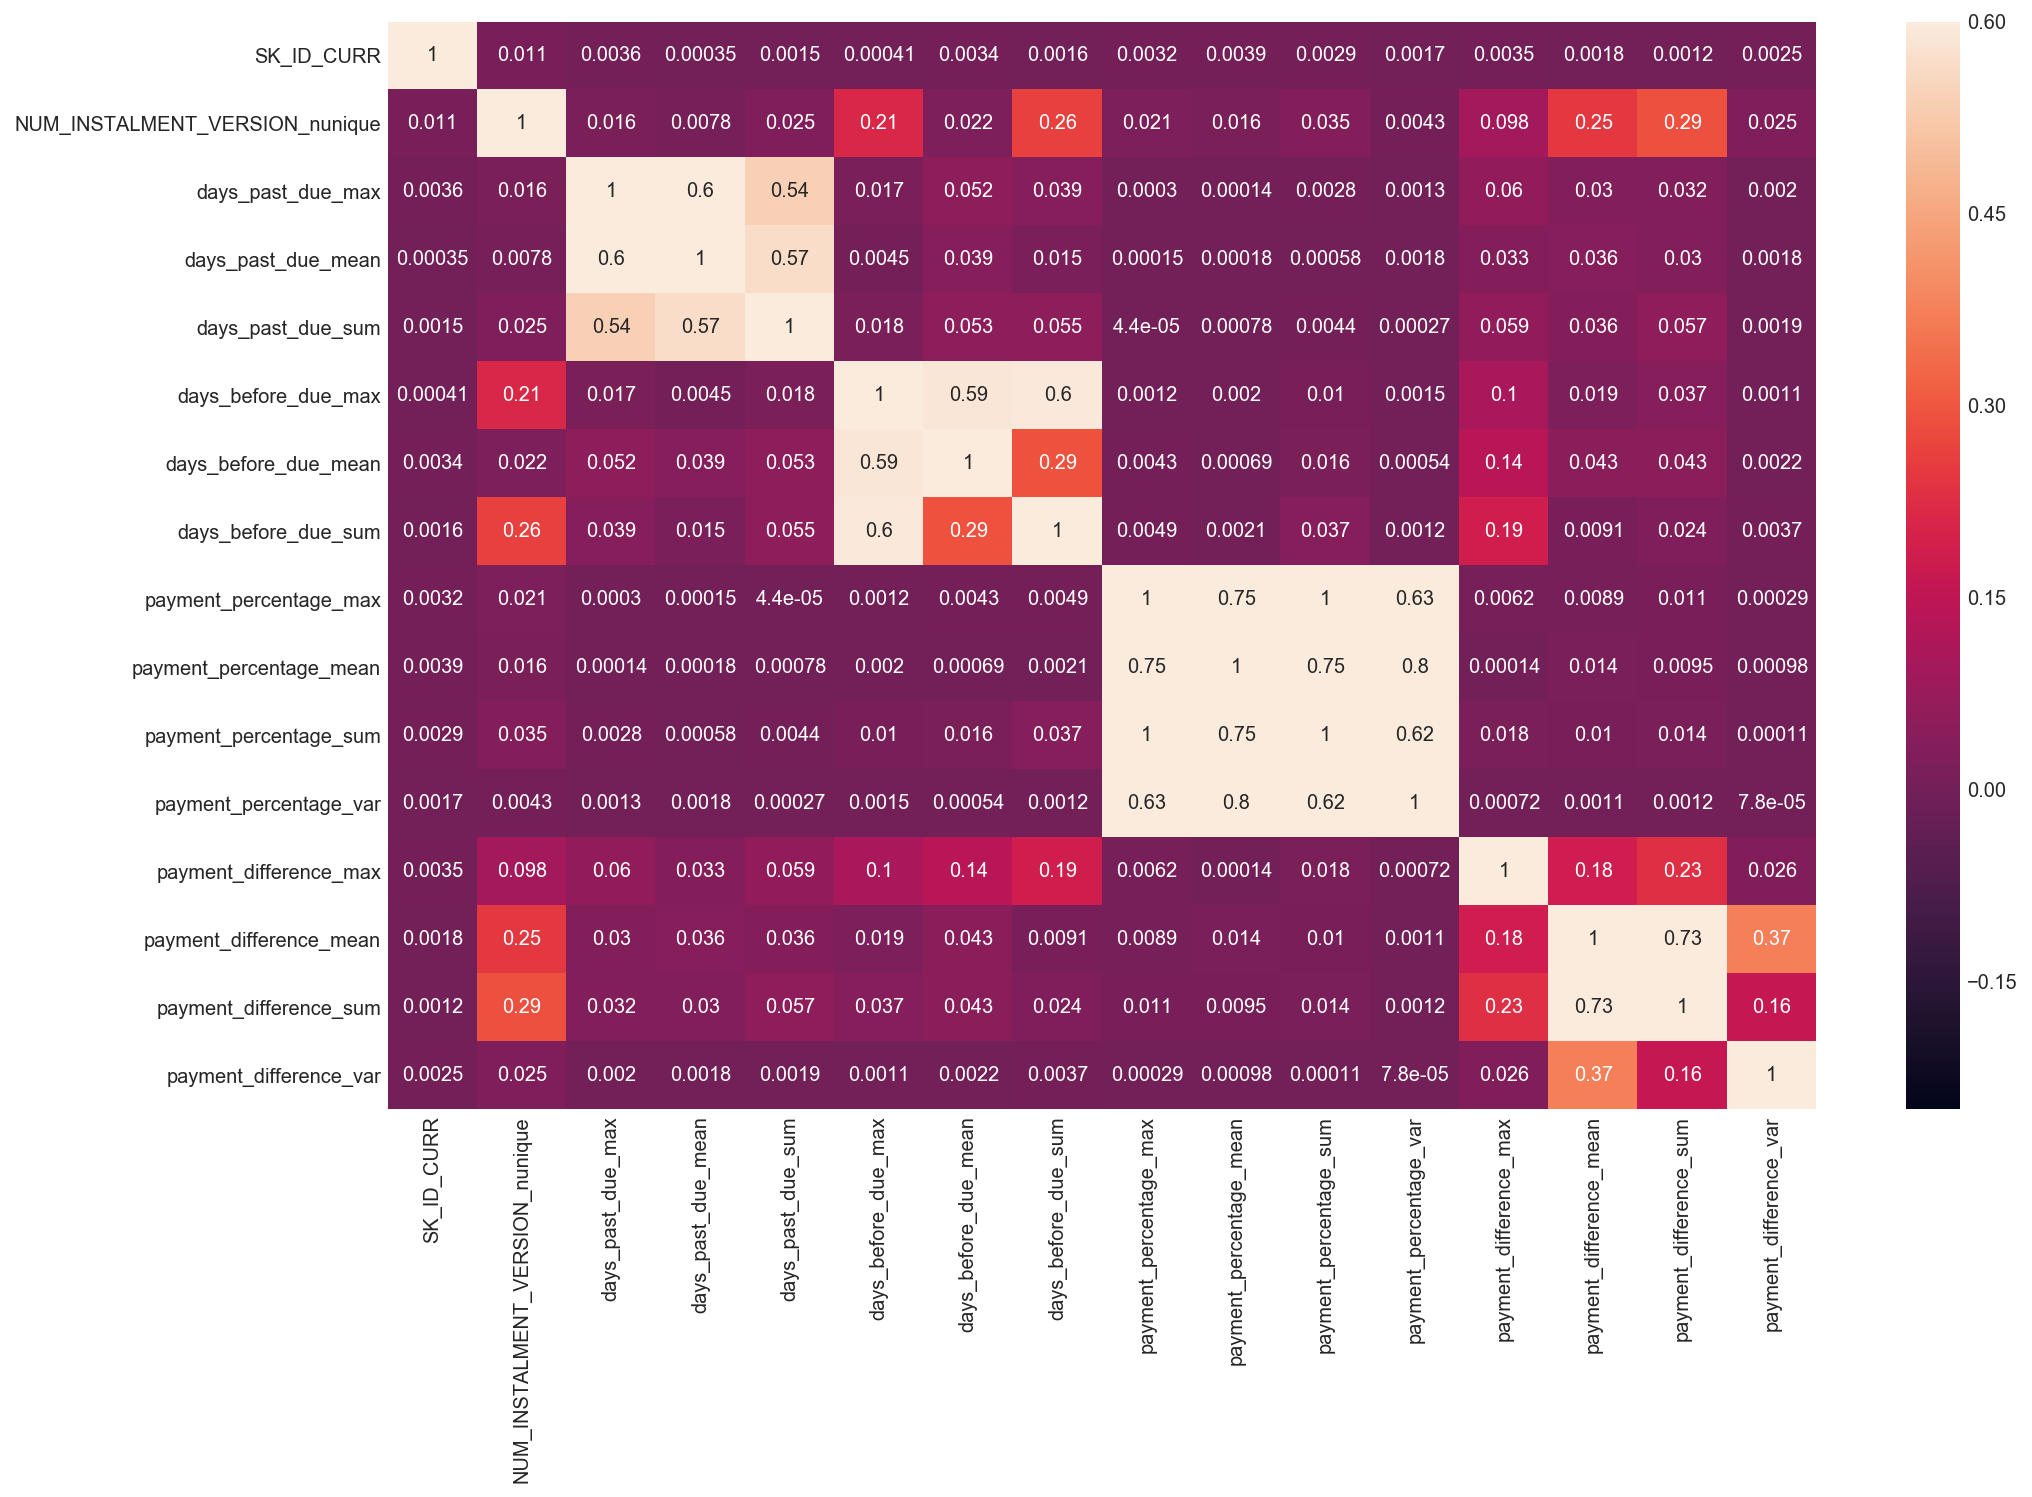

In [91]:
plt.figure(figsize = (16, 10))

sns.heatmap(corr_matrix_payment, vmin = -0.25, annot = True, vmax = 0.6)

In [92]:
to_drop_payment = [column for column in upper_payment.columns if any(upper_payment[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop_payment)))

There are 1 columns to remove.


In [93]:
print(to_drop_payment)

['payment_percentage_sum']


In [94]:
# drop 1 col
payment = payment.drop(columns = to_drop_payment)

** Remove collinear features in pos (7 cols)**

In [53]:
#pos = pd.read_csv('pos_cash_balance.csv')
#pos = pos.drop(columns='Unnamed: 0')

In [95]:
corr_matrix_pos = pos.corr().abs()
upper_pos = corr_matrix_pos.where(np.triu(np.ones(corr_matrix_pos.shape), k=1).astype(np.bool))
upper_pos.head()

,SK_ID_CURR,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_size,SK_DPD_max,SK_DPD_DEF_max,SK_DPD_DEF_mean
SK_ID_CURR,NaN,0.00089,0.000190,0.002619,0.001511,0.001685,0.000656
MONTHS_BALANCE_max,NaN,NaN,0.689549,0.237288,0.015843,0.004447,0.001624
MONTHS_BALANCE_mean,NaN,NaN,NaN,0.251703,0.068474,0.026148,0.015063
MONTHS_BALANCE_size,NaN,NaN,NaN,NaN,0.016397,0.024223,0.007060
SK_DPD_max,NaN,NaN,NaN,NaN,NaN,0.178458,0.179268


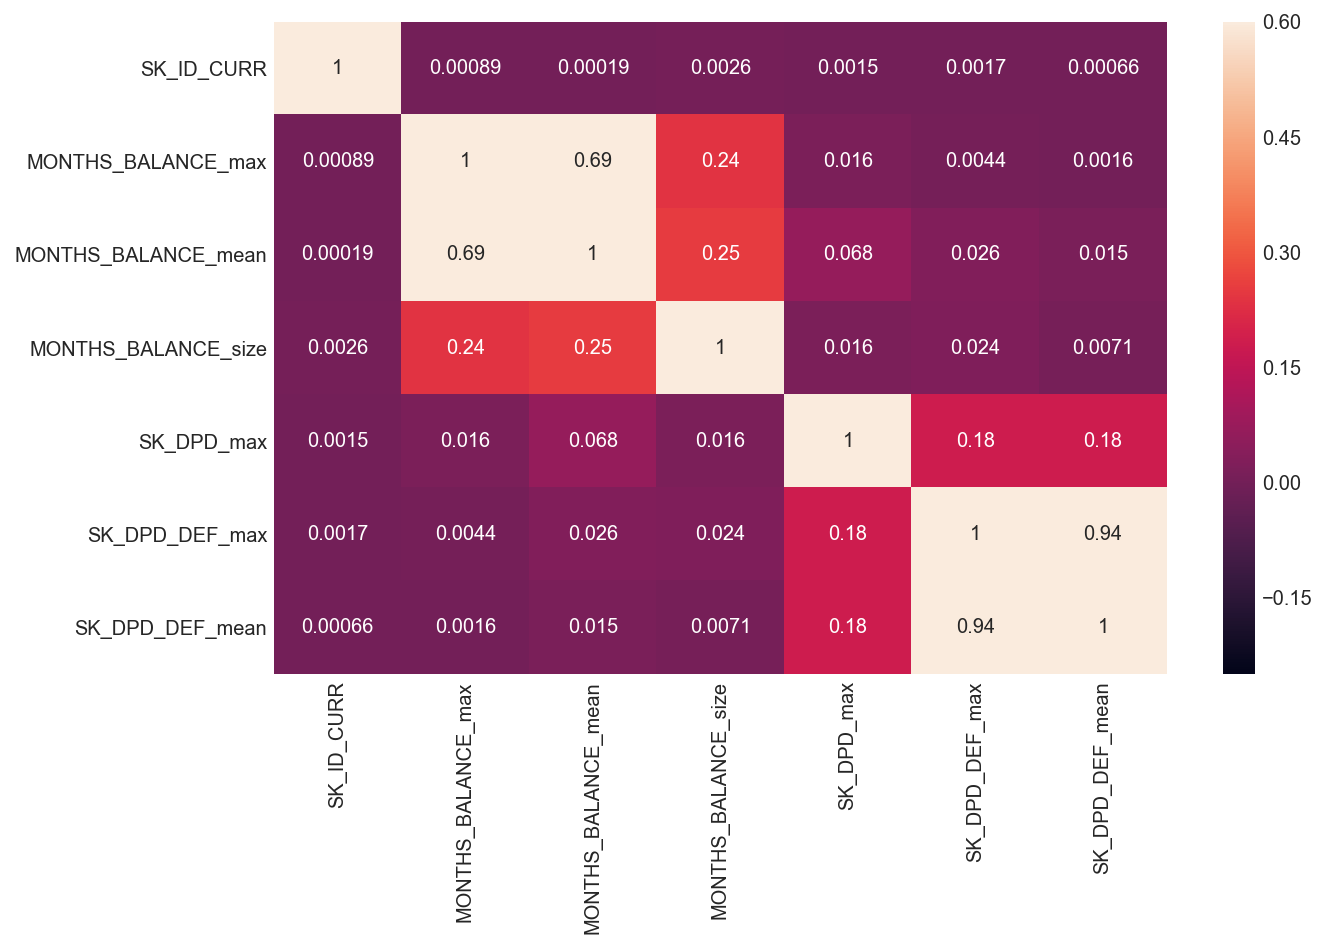

In [96]:
plt.figure(figsize = (10, 6))

sns.heatmap(corr_matrix_pos, vmin = -0.25, annot = True, vmax = 0.6)

In [97]:
to_drop_pos = [column for column in upper_pos.columns if any(upper_pos[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop_pos)))

There are 1 columns to remove.


In [98]:
print(to_drop_pos)

['SK_DPD_DEF_mean']


In [99]:
# drop 1 col
pos = pos.drop(columns=to_drop_pos)

** Remove collinear features in app_train (132 cols)**

In [100]:
app_train.shape

(307507, 132)

In [101]:
corr_matrix_train = app_train.corr().abs()
upper_train = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(np.bool))
upper_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_CREDIT_TERM,DAYS_EMPLOYED_DAYS_BIRTH_RATIO,CREDIT_GOODS_PRICES_RATIO,INC_PER_CHLD,INC_BY_ORG,NEW_SOURCES_PROD,NEW_EXT_SOURCES_MEAN,NEW_EXT_SOURCES_STD
SK_ID_CURR,NaN,0.002111,0.001120,0.001821,0.000350,0.000440,0.000241,0.000852,0.001500,0.000101,...,0.001733,0.002360,0.000317,0.000123,0.001037,0.000554,0.000632,0.003185,0.001241,0.001600
TARGET,NaN,NaN,0.019189,0.003982,0.030371,0.012818,0.039647,0.037225,0.078242,0.074957,...,0.007729,0.014262,0.012703,0.067952,0.069434,0.012529,0.034586,0.188556,0.222054,0.044108
CNT_CHILDREN,NaN,NaN,NaN,0.012884,0.002151,0.021381,0.001818,0.025577,0.330937,0.061139,...,0.016008,0.002291,0.020752,0.009991,0.022587,0.274392,0.168572,0.106777,0.066123,0.003990
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.156871,0.191658,0.159610,0.074795,0.027261,0.013003,...,0.108190,0.153033,0.026788,0.010677,0.021362,0.909001,0.087138,0.015654,0.034790,0.001804
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.770137,0.986971,0.099742,0.055434,0.091304,...,0.651096,0.373918,0.558791,0.066808,0.017464,0.212332,0.076196,0.158110,0.143682,0.033965


In [102]:
to_drop_train = [column for column in upper_train.columns if any(upper_train[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop_train)))

There are 42 columns to remove.


In [103]:
print(to_drop_train)

['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'ELEVATORS_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED_DAYS_BIRTH_RATIO', 'INC_PER_CHLD', 'NEW_EXT_SOURCES_MEAN']


In [104]:
# drop 42 cols
app_train = app_train.drop(columns=to_drop_train)

## 2.2  Remove Missing Values

A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 70% missing values, they will be removed.

Most models (including those in sk-Learn) cannot handle missing values, so we will have to fill these in before machine learning. The Gradient Boosting Machine (at least in LightGBM) can handle missing values.

Imputing missing values always makes me a little uncomfortable because we are adding information that actually isn't in the dataset. Since we are going to be evaluating several models, we will have to use some form of imputation.

For now, we will focus on removing columns above the threshold.

In [65]:
missing_values_table(app_train).head(5)

There are 36 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,214862,69.9
NONLIVINGAPARTMENTS_AVG,213512,69.4
FONDKAPREMONT_MODE,210293,68.4
FLOORSMIN_AVG,208640,67.8
YEARS_BUILD_AVG,204486,66.5


In [67]:
missing_values_table(prev_agg).head(5)

There are 10 columns that have missing values.


,Missing Values,% of Total Values
PREV_AMT_DOWN_PAYMENT_MIN,20104,5.9
PREV_AMT_DOWN_PAYMENT_MAX,20104,5.9
PREV_RATE_DOWN_PAYMENT_MIN,20104,5.9
PREV_RATE_DOWN_PAYMENT_MAX,20104,5.9
PREV_AMT_GOODS_PRICE_MIN,1064,0.3


In [68]:
missing_values_table(bureau_agg).head(5)

There are 8 columns that have missing values.


,Missing Values,% of Total Values
BURO_AMT_ANNUITY_MAX,187587,61.3
BURO_AMT_ANNUITY_MEAN,187587,61.3
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,92840,30.4
BURO_DAYS_CREDIT_VAR,41520,13.6
BURO_AMT_CREDIT_SUM_LIMIT_MEAN,25308,8.3


In [74]:
# drop 42 cols on test data set
app_test = app_test.drop(columns=to_drop_train)

In [69]:
missing_values_table(payment).head(5)

There are 6 columns that have missing values.


,Missing Values,% of Total Values
payment_percentage_var,19427,5.7
payment_difference_var,19413,5.7
payment_percentage_max,9,0.0
payment_percentage_mean,9,0.0
payment_difference_max,9,0.0


In [70]:
missing_values_table(pos).head(5)

There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [227]:
## There is not any features having more than 70% nan values
## I decided to fill all nan by zeros in all dataframes

In [105]:
app_train = app_train.fillna(0)
prev_agg = prev_agg.fillna(0)
bureau_agg = bureau_agg.fillna(0)
payment = payment.fillna(0)
pos = pos.fillna(0)

In [56]:
app_train.shape

(307507, 90)

In [57]:
prev_agg.shape

(338857, 154)

In [58]:
bureau_agg.shape

(305811, 40)

In [59]:
payment.shape

(339587, 15)

In [60]:
pos.shape

(337252, 6)

# 3. Merging all tables into one table

In [106]:
app_train = pd.merge(app_train, prev_agg, on = 'SK_ID_CURR', how = 'left')

In [107]:
app_train = pd.merge(app_train, bureau_agg, on = 'SK_ID_CURR', how = 'left')

In [108]:
app_train = pd.merge(app_train, payment, on = 'SK_ID_CURR', how = 'left')

In [109]:
app_train = pd.merge(app_train, pos, on = 'SK_ID_CURR', how = 'left')

In [110]:
app_train.shape

(307507, 301)

# 4. Encoding categorical variables

In [111]:
train_labels = app_train["TARGET"]
train_ids = app_train['SK_ID_CURR']

# Categorical features with Binary encode (0 or 1; two categories)
for binary_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    app_train[binary_feature], uniques = pd.factorize(app_train[binary_feature])
    
app_train_dummy = pd.get_dummies(app_train)

app_train_dummy = app_train_dummy.drop(columns = ['TARGET','SK_ID_CURR'])

print('Training set full shape: ', app_train_dummy.shape)

Training set full shape:  (307507, 425)


# 5. Feature Selection using Feature Importances

In [112]:
gc.collect()

201

In [113]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(app_train_dummy.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 1000, class_weight = 'balanced')

In [114]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(app_train_dummy, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.784688
Early stopping, best iteration is:
[177]	valid_0's auc: 0.7848
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.780545
Early stopping, best iteration is:
[132]	valid_0's auc: 0.781417


In [115]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(app_train_dummy.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [116]:
# Top-10 important features
feature_importances.head(10)

,feature,importance
70,ANNUITY_CREDIT_TERM,160.0
26,EXT_SOURCE_2,151.0
8,DAYS_BIRTH,125.5
27,EXT_SOURCE_3,114.0
91,PREV_CNT_PAYMENT_MEAN,99.5
25,EXT_SOURCE_1,91.0
71,CREDIT_GOODS_PRICES_RATIO,87.0
9,DAYS_EMPLOYED,77.5
73,NEW_SOURCES_PROD,71.0
6,AMT_ANNUITY,67.0


In [117]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

feature_importances.tail()

There are 129 features with 0.0 importance


,feature,importance
315,NAME_HOUSING_TYPE_Co-op apartment,0.0
208,PREV_NAME_SELLER_INDUSTRY_nan_MEAN,0.0
207,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,0.0
206,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,0.0
337,OCCUPATION_TYPE_Secretaries,0.0


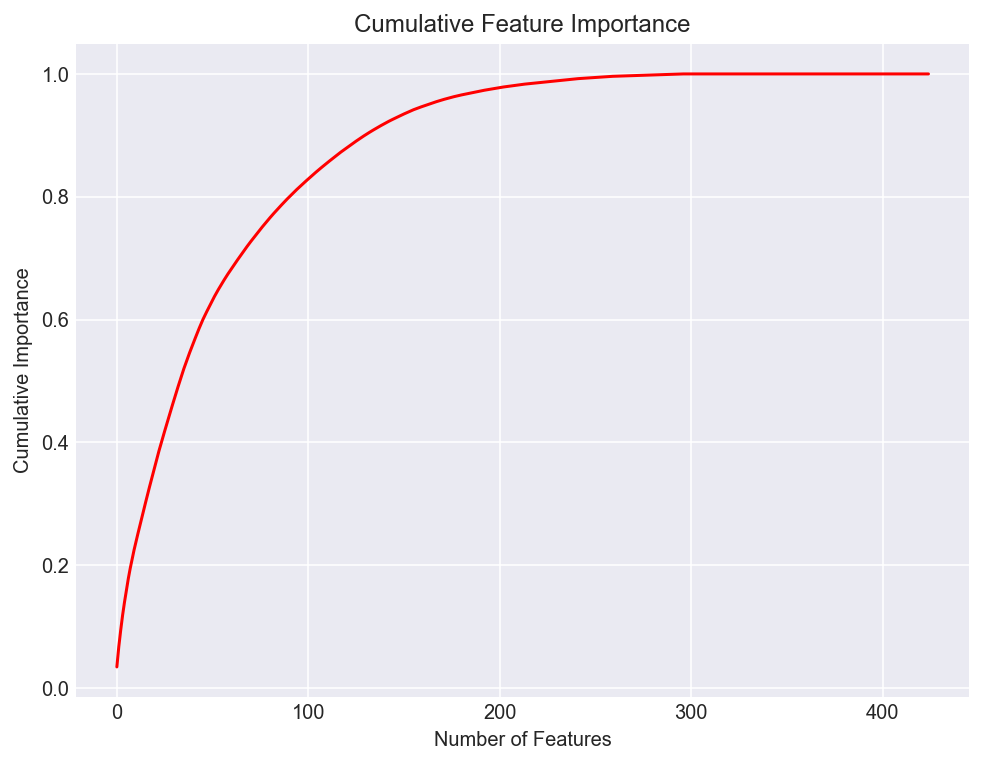

131 features required for 0.90 of cumulative importance


In [118]:
# Plotting Cumulative Feature Importance
    
# Sort features according to importance
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()

feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])


plt.figure(figsize = (8, 6))
plt.plot(list(range(len(feature_importances))), feature_importances['cumulative_importance'], 'r-')
plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Feature Importance');
plt.show();

threshold1 = 0.9
importance_index = np.min(np.where(feature_importances['cumulative_importance'] > threshold1))
print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold1))
    

In [119]:
# Remove zero importance features (129)
app_train_dummy = app_train_dummy.drop(columns = zero_features)

print('Training shape: ', app_train_dummy.shape)

Training shape:  (307507, 296)


In [120]:
app_train_dummy['TARGET'] = train_labels
app_train_dummy['SK_ID_CURR'] = train_ids

In [121]:
app_train_dummy.to_csv('app_train_dummy.csv')

In [ ]:
# Move to other notebook for train_test splitting, upsampling, model building and evaluation